# Анализ вакансий DS и DA

**Описание проекта:** <br>

Исследование вакансий Data Scientist и Data Analyst.

**Цель исследования:** <br>

Показать чем различаются предлагаемые вакансии Data Scientist и Data Analyst.

**План работы:**

1) Загрузим данные и подготовим их к анализу.
2) Проведем исследовательский анализ данных.
3) Определение доли грейдов Junior, Junior+, Middle, Senior среди вакансий Аналитик данных и Специалист по Data Science.
4) Определение наиболее желаемых кандидатов на вакансии Аналитик данных и Специалист по Data Science по следующим параметрам: самые важные hard-skils, самые важные soft-skils. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.
5) Определение типичного места работы для Аналитика данных и специалист по Data Science по следующим параметрам: ТОП-работодателей, зарплата, тип занятости, график работы. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.
6) Расчет помесячной динамики количества вакансий для Аналитика данных и специалиста по Data Science. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.
7) Формулирование выводов и рекомендаций.
8) Создание презентации.

**Описание данных:**

В нашем распоряжении два датасета о активных вакансиях представленных на сайте HH.ru 13.05.2024 за моследний месяц. Данные получены из API HH.ru.

`da.csv` - вакансии аналитиков данных<br>
`ds.csv` - вакансии датасаентистов

Столбцы в двух таблицах идентичны:

- `id` -  уникальный номер вакансии
- `name` - название вакансии
- `published_at` - дата публикации вакансии(Для каждой вакансии мы сохраням только первую дату публикации)
- `alternate_url` - ссылка на вакансию
- `type` - тип вакансии
- `employer` - работодатель
- `department` - подразделение работодателя
- `area` - регион вакансии
- `experience` - требуемый опыт работы
- `key_skills` - требуемые скиллы
- `schedule` - график работы
- `employment` - тип занятости
- `description` - подробное описание вакансии
- `salary_from` - зарплата от
- `salary_to` -  зарплата до
- `currency_salary` - валюта зарплаты

---

## Загрузка данныx и подготовка их к анализу

---

In [1]:
import warnings
import pandas as pd
from pymystem3 import Mystem
import numpy as np
from tqdm.notebook import tqdm
import re

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import requests

warnings.filterwarnings("ignore", "use_inf_as_na")
sns.set_theme(style="whitegrid", palette="pastel")

In [2]:
# определим цвета для наших графиков
COLORS = {
    'da': '#A03B2A', 
    'ds': '#266292',
    }

COLORS_DA = {
    'Полная занятость': '#A03B2A',
    'Стажировка': '#c5695a',
    'Проектная работа': '#e99b8e',
    'Частичная занятость': '#771606',
    'Полный день': '#A03B2A',
    'Удаленная работа': '#c5695a',
    'Гибкий график': '#e99b8e',
    'Сменный график': '#771606',
    'Вахтовый метод': '#A03B2A',
    'Junior (no experience)': '#e99b8e',
    'Junior+ (1-3 years)': '#c5695a',
    'Middle (3-6 years)': '#A03B2A',
    'Senior (6+ years)': '#771606',
    'ЗП не указана': '#A03B2A',
    'Меньше 100 тысяч': '#e99b8e',
    'От 100 тысяч до 200 тысяч': '#c5695a',
    'От 200 тысяч до 300 тысяч': '#771606',
    'Больше 300 тысяч': '#A03B2A',

}

COLORS_DS = {
    'Полная занятость': '#266292',
    'Стажировка': '#518dbd',
    'Проектная работа': '#82bae7',
    'Частичная занятость': '#083d67',
    'Полный день': '#266292',
    'Удаленная работа': '#518dbd',
    'Гибкий график': '#82bae7',
    'Сменный график': '#083d67',
    'Вахтовый метод': '#023156',
    'Junior (no experience)': '#82bae7',
    'Junior+ (1-3 years)': '#518dbd',
    'Middle (3-6 years)': '#266292',
    'Senior (6+ years)': '#083d67',
    'ЗП не указана': '#266292',
    'Меньше 100 тысяч': '#82bae7',
    'От 100 тысяч до 200 тысяч': '#266292',
    'От 200 тысяч до 300 тысяч': '#083d67',
    'Больше 300 тысяч': '#023156',
}

---

### Общая информация о данных

---

Посмотрим как выглядят данные

In [3]:
# приведем published_at сразу в формат даты
da = pd.read_csv('data/da.csv', parse_dates=['published_at'])
da.sample(5)

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,salary_from,salary_to,currency_salary
107,98081879,Аналитик данных со знанием SQL,2024-04-27 15:40:01+03:00,https://hh.ru/vacancy/98081879,Открытая,СБЕР,Сбер для экспертов,Екатеринбург,От 1 года до 3 лет,[],Полный день,Полная занятость,Наша цель – обеспечить внутренних клиентов сво...,NaN,NaN,NaN
536,97727205,Стажер дата-аналитик в центр мониторинга,2024-04-23 15:00:59+03:00,https://hh.ru/vacancy/97727205,Открытая,Changellenge,NaN,Москва,Нет опыта,[],Полный день,Стажировка,"Банк ВТБ — системообразующий банк, в котором р...",NaN,NaN,NaN
462,97048208,Специалист по аналитике данных и построению фи...,2024-04-15 20:02:00+03:00,https://hh.ru/vacancy/97048208,Открытая,СБЕР,Сбер для экспертов,Москва,От 3 до 6 лет,[],Полный день,Полная занятость,В команду кредитных карт в блоке Транзакционны...,NaN,NaN,NaN
215,97752822,Аналитик данных / Data Scientist,2024-04-23 18:59:15+03:00,https://hh.ru/vacancy/97752822,Открытая,Эттон,NaN,Казань,От 3 до 6 лет,"['data Scientist', 'Big Data', 'Machine Learni...",Полный день,Полная занятость,Если ты … Имеешь профильное образование по с...,NaN,NaN,NaN
252,98751506,Оператор 1С (аналитик данных),2024-05-13 08:01:51+03:00,https://hh.ru/vacancy/98751506,Открытая,АктивПромКапитал,NaN,Екатеринбург,Нет опыта,"['Деловая переписка', 'работа с выставленными ...",Полный день,Полная занятость,ООО АктивПромКапитал - управляющая компания мн...,40000.0,40000.0,RUR


In [4]:
# приведем published_at сразу в формат даты
ds = pd.read_csv('data/ds.csv', parse_dates=['published_at'])
ds.sample(5)

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,salary_from,salary_to,currency_salary
97,98460411,Middle ML Data Scientist,2024-05-06 12:30:42+03:00,https://hh.ru/vacancy/98460411,Открытая,Гибрид,NaN,Тамбов,От 1 года до 3 лет,"['Python', 'Анализ данных', 'Математическая ст...",Удаленная работа,Полная занятость,Hybrid — независимый adtech холдинг. Представл...,NaN,NaN,NaN
305,98767667,Senior Data Scientist (Кредиты физический лиц),2024-05-13 09:57:09+03:00,https://hh.ru/vacancy/98767667,Открытая,СБЕР,Сбер для экспертов,Москва,От 3 до 6 лет,[],Полный день,Полная занятость,Вакансия в Управлении Моделирования и Исследов...,NaN,NaN,NaN
300,98612539,Middle/Senior Data Scientist,2024-05-08 13:04:23+03:00,https://hh.ru/vacancy/98612539,Открытая,СБЕР,Сбер для экспертов,Москва,От 3 до 6 лет,[],Полный день,Полная занятость,Мы разрабатываем и внедряем ML решения для инт...,NaN,NaN,NaN
235,97320257,Middle/Senior разработчик систем обработки ест...,2024-04-18 13:01:52+03:00,https://hh.ru/vacancy/97320257,Открытая,Университет Иннополис,NaN,Казань,От 3 до 6 лет,"['Python', 'Tensorflow', 'PyTorch', 'Docker']",Полный день,Полная занятость,Привет! На связи команда Университета Иннополи...,NaN,NaN,NaN
151,96978481,Data Scientist/Analyst,2024-04-15 09:31:31+03:00,https://hh.ru/vacancy/96978481,Открытая,RapidSeedbox ltd,NaN,Минск,От 3 до 6 лет,"['Google Analytics', 'Data Analysis', 'Python'...",Удаленная работа,Полная занятость,Our core values are: ✔️Excellence in everythin...,1000.0,1500.0,USD


Можно заметить, что есть пустые списки в колонке `key_skills`.

---

Добавим флаговую переменную(которая будет принимать два значения "da" или "ds") и объеденим данные, чтобы на этапе обработке было удобнее с ними работать

In [5]:
# Создаем переменные
da['name_type'] = 'da'
ds['name_type'] = 'ds'

# объеденяем таблицы
vacancies = pd.concat((da, ds))
start_data_size = vacancies.shape[0]

---

Посмотрим общую информацию о датасете

In [6]:
vacancies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1406 entries, 0 to 437
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype                    
---  ------           --------------  -----                    
 0   id               1406 non-null   int64                    
 1   name             1406 non-null   object                   
 2   published_at     1406 non-null   datetime64[ns, UTC+03:00]
 3   alternate_url    1406 non-null   object                   
 4   type             1406 non-null   object                   
 5   employer         1406 non-null   object                   
 6   department       415 non-null    object                   
 7   area             1406 non-null   object                   
 8   experience       1406 non-null   object                   
 9   key_skills       1406 non-null   object                   
 10  schedule         1406 non-null   object                   
 11  employment       1406 non-null   object                   
 12

Видно что работодатели зачастую не вносят информацию о зарплате. 

---

### Поиск дубликатов

---

Мы хотим сравнить две группы аналитиков и датасаентистов. В наших данных есть смежные вакансии - Аналитик данных/Data Scientist, так как непонятно к какой группе их отнести, давайте посмотрим сколько этих данных в нашем датасете и удалим их.

In [7]:
grid = (vacancies.name.str.lower().str.contains(r'data scien')
    & (vacancies.name.str.lower().str.contains(r'analyst')
    | vacancies.name.str.lower().str.contains(r'аналитик')) 
    & (~vacancies.name.str.lower().str.contains(r'видеоаналитика')))
vacancies[grid].sort_values(by='id')

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,salary_from,salary_to,currency_salary,name_type
200,92601521,Эксперт Группа аналитики и моделирования (Data...,2024-04-23 17:39:17+03:00,https://hh.ru/vacancy/92601521,Открытая,ВТБ Лизинг,NaN,Москва,От 1 года до 3 лет,"['Python', 'Математическое моделирование', 'Ма...",Полный день,Полная занятость,"Крупнейшая лизинговая компания в России, являе...",NaN,NaN,NaN,ds
617,92601521,Эксперт Группа аналитики и моделирования (Data...,2024-04-23 17:39:17+03:00,https://hh.ru/vacancy/92601521,Открытая,ВТБ Лизинг,NaN,Москва,От 1 года до 3 лет,"['Python', 'Математическое моделирование', 'Ма...",Полный день,Полная занятость,"Крупнейшая лизинговая компания в России, являе...",NaN,NaN,NaN,da
129,93849154,Аналитик данных (Data Analyst / Data Scientist),2024-04-19 09:13:46+03:00,https://hh.ru/vacancy/93849154,Открытая,Белгазпромбанк,NaN,Минск,От 1 года до 3 лет,[],Полный день,Полная занятость,ОАО “Белгазпромбанк” приглашает стать частью н...,NaN,NaN,NaN,da
55,93849154,Аналитик данных (Data Analyst / Data Scientist),2024-04-19 09:13:46+03:00,https://hh.ru/vacancy/93849154,Открытая,Белгазпромбанк,NaN,Минск,От 1 года до 3 лет,[],Полный день,Полная занятость,ОАО “Белгазпромбанк” приглашает стать частью н...,NaN,NaN,NaN,ds
112,94606498,Бизнес-аналитик со знанием SQL (удаленно)/Data...,2024-05-08 16:01:26+03:00,https://hh.ru/vacancy/94606498,Открытая,ПКБ,NaN,Москва,От 1 года до 3 лет,"['Работа в команде', 'SQL', 'Умение работать в...",Удаленная работа,Полная занятость,ПКБ — технологичная клиентоориентированная ком...,NaN,NaN,NaN,ds
326,94606498,Бизнес-аналитик со знанием SQL (удаленно)/Data...,2024-05-08 16:01:26+03:00,https://hh.ru/vacancy/94606498,Открытая,ПКБ,NaN,Москва,От 1 года до 3 лет,"['Работа в команде', 'SQL', 'Умение работать в...",Удаленная работа,Полная занятость,ПКБ — технологичная клиентоориентированная ком...,NaN,NaN,NaN,da
271,95707799,Аналитик / Data scientist,2024-05-12 13:03:16+03:00,https://hh.ru/vacancy/95707799,Открытая,ЭКОПСИ Консалтинг,NaN,Москва,От 1 года до 3 лет,[],Полный день,Полная занятость,ЭКОПСИ Консалтинг – лидер рынка управленческог...,NaN,NaN,NaN,ds
765,95707799,Аналитик / Data scientist,2024-05-12 13:03:16+03:00,https://hh.ru/vacancy/95707799,Открытая,ЭКОПСИ Консалтинг,NaN,Москва,От 1 года до 3 лет,[],Полный день,Полная занятость,ЭКОПСИ Консалтинг – лидер рынка управленческог...,NaN,NaN,NaN,da
186,95805024,Аналитик данных в отдел планирования и прогноз...,2024-04-23 14:47:58+03:00,https://hh.ru/vacancy/95805024,Открытая,"Бристоль, сеть магазинов",NaN,Москва,От 3 до 6 лет,[],Полный день,Полная занятость,"Обязанности: Прогнозирование спроса, построен...",NaN,218400.0,RUR,ds
580,95805024,Аналитик данных в отдел планирования и прогноз...,2024-04-23 14:47:58+03:00,https://hh.ru/vacancy/95805024,Открытая,"Бристоль, сеть магазинов",NaN,Москва,От 3 до 6 лет,[],Полный день,Полная занятость,"Обязанности: Прогнозирование спроса, построен...",NaN,218400.0,RUR,da


Мы видим что каждая такая вакансия попала в обе выборке.

In [8]:
print(f'Количество смежных вакансий - {vacancies[grid].shape[0]}')

Количество смежных вакансий - 58


У нас 58 таких наблюдений, давайте их удалим. 

In [9]:
vacancies = vacancies[~grid].sort_values(by='id')

In [10]:
print(f'Удалили {1 - vacancies.shape[0] / start_data_size:.2%} данных')

Удалили 4.13% данных


---

Создадим новую переменную `published_date`

In [11]:
vacancies['published_date'] = vacancies.published_at.dt.date

---

Посмотрим наличие дубликатов по `id`

In [12]:
n_dupl = vacancies.duplicated(
    subset='id'
).sum()
print(f'Количество дубликатов - {n_dupl}')

Количество дубликатов - 0


Проверим есть ли у нас неявные дубликаты

In [13]:
vacancies[
    vacancies.duplicated(
        subset=['name', 'employer', 'department', 'area', 'description'],
        keep=False
    )].sort_values(by=['name', 'employer', 'published_date'])

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,salary_from,salary_to,currency_salary,name_type,published_date
191,97121462,Senior Data Scientist (LLM),2024-04-16 13:48:13+03:00,https://hh.ru/vacancy/97121462,Открытая,Правительство Москвы,NaN,Москва,Нет опыта,[],Полный день,Полная занятость,Работа в Правительстве Москвы — это возможност...,NaN,NaN,NaN,ds,2024-04-16
137,98602891,Senior Data Scientist (LLM),2024-05-08 11:13:13+03:00,https://hh.ru/vacancy/98602891,Открытая,Правительство Москвы,NaN,Москва,Нет опыта,[],Полный день,Полная занятость,Работа в Правительстве Москвы — это возможност...,NaN,NaN,NaN,ds,2024-05-08
405,95965579,Аналитик данных,2024-04-23 15:18:00+03:00,https://hh.ru/vacancy/95965579,Открытая,ГКУ Центр занятости населения города Москвы,NaN,Москва,От 1 года до 3 лет,[],Полный день,Полная занятость,Один из ключевых партнёров Центра занятости на...,100000.0,NaN,RUR,da,2024-04-23
354,97876939,Аналитик данных,2024-04-25 09:50:39+03:00,https://hh.ru/vacancy/97876939,Открытая,ГКУ Центр занятости населения города Москвы,NaN,Москва,От 1 года до 3 лет,[],Полный день,Полная занятость,Один из ключевых партнёров Центра занятости на...,80000.0,100000.0,RUR,da,2024-04-25
272,97929624,Аналитик данных,2024-04-25 17:24:21+03:00,https://hh.ru/vacancy/97929624,Открытая,ГКУ Центр занятости населения города Москвы,NaN,Москва,От 1 года до 3 лет,[],Полный день,Полная занятость,Один из ключевых партнёров Центра занятости на...,150000.0,NaN,RUR,da,2024-04-25
848,97929739,Аналитик данных,2024-04-25 17:27:28+03:00,https://hh.ru/vacancy/97929739,Открытая,ГКУ Центр занятости населения города Москвы,NaN,Москва,От 1 года до 3 лет,[],Полный день,Полная занятость,Один из ключевых партнёров Центра занятости на...,NaN,NaN,NaN,da,2024-04-25
777,98779185,Аналитик данных,2024-05-13 11:10:12+03:00,https://hh.ru/vacancy/98779185,Открытая,ГКУ Центр занятости населения города Москвы,NaN,Москва,От 1 года до 3 лет,[],Полный день,Полная занятость,Один из ключевых партнёров Центра занятости на...,NaN,90000.0,RUR,da,2024-05-13


Удалим дубликаты

In [14]:
vacancies.drop_duplicates(
    subset=['name', 'employer', 'department', 'area', 'description'],
    keep=False, inplace=True
)

In [15]:
print(f'Удалили {1 - vacancies.shape[0] / start_data_size:.2%} данных')

Удалили 4.62% данных


---

### Поиск аномальных значений

---

Посмотрим какие названия вакансий у нас в датасете

In [16]:
vacancies.name.value_counts()[:10]

name
Аналитик данных            174
Data Scientist              76
Data Analyst                50
Ведущий аналитик данных     15
Senior Data Scientist       11
Аналитик баз данных         10
Data аналитик                9
Senior Data Analyst          9
Data scientist               8
Junior Data Analyst          8
Name: count, dtype: int64

In [17]:
vacancies.name.value_counts()[-10:]

name
Data Engineer + Системный аналитик (Лаборатория СберИндекс)    1
Senior Data Scientist (LLM)                                    1
Аналитик отдела продаж (базы данных)                           1
Аналитик данных контактных центров                             1
Ведущий аналитик данных, Группа операционной аналитики         1
Senior Data scientist (Дирекция цифрового развития)            1
Аналитик по сопровождению хранилищ данных                      1
Data аналитик junior (блок C&B/Power BI/Python)                1
Руководитель отдела аналитики данных (BI/ML/DWH)               1
Стажер в отдел аналитики данных                                1
Name: count, dtype: int64

Все просмотреть нет возможности, но тут вроде порядок.

---

Посмотрим минимальные и максимальные даты

In [18]:
print(f'Минимальная дата - {vacancies.published_at.min().strftime("%Y-%m-%d %X")}')
print(f'Максимальная дата - {vacancies.published_at.max().strftime("%Y-%m-%d %X")}')

Минимальная дата - 2024-04-13 15:58:35
Максимальная дата - 2024-05-13 14:01:05


У нас самая старая вакансия 13 апреля 2024 года, а самая новая 13 мая 2024 года. Все правильно данные за последний месяц.

Посмотрим наши вакансии в динамике.

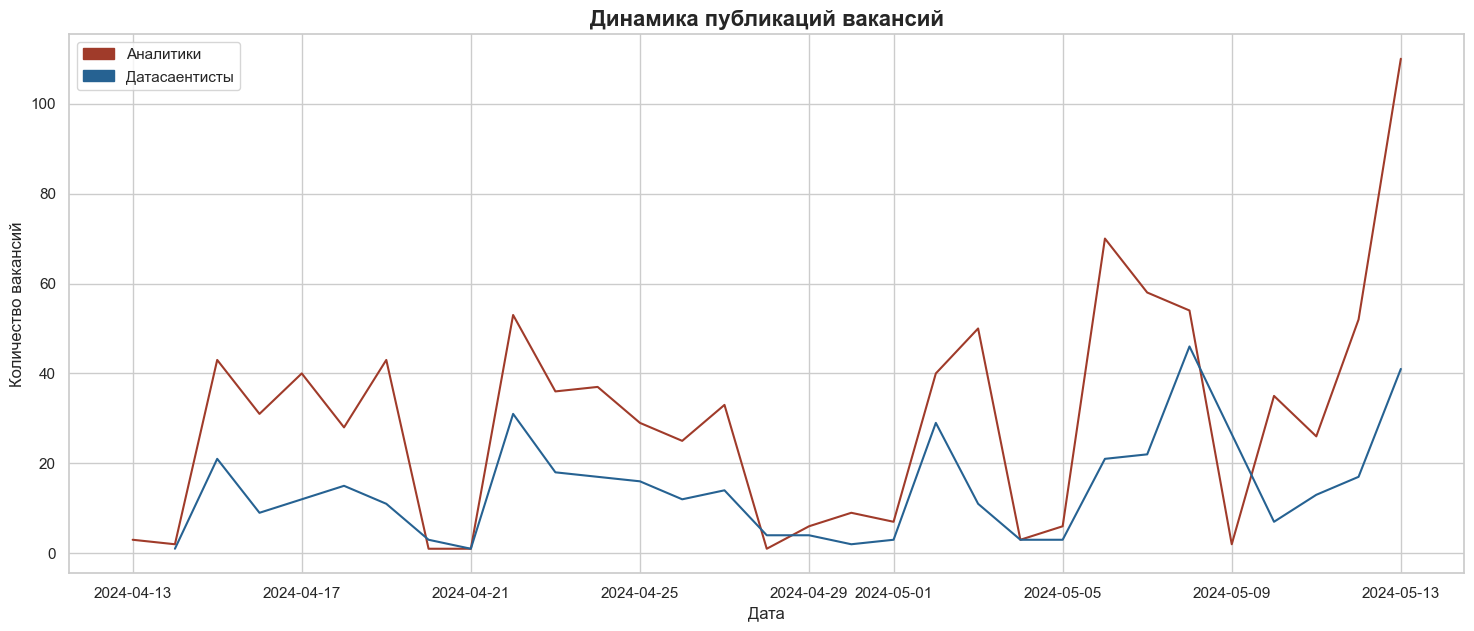

In [19]:
fig, ax = plt.subplots(figsize=(18, 7))

# получаем данные для графиков
df = vacancies.groupby(['name_type', 'published_date'], as_index=False).id.count()

# отрисовываем графики
sns.lineplot(df[df.name_type == 'da'], x='published_date', y='id', color=COLORS['da'], ax=ax)
sns.lineplot(df[df.name_type == 'ds'], x='published_date', y='id', color=COLORS['ds'], ax=ax)

# Добавляем названия
plt.title('Динамика публикаций вакансий', fontsize=16, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Количество вакансий')

# добавляем легенду
analyst_patch = mpatches.Patch(color=COLORS['da'], label='Aналитики')
datascience_patch = mpatches.Patch(color=COLORS['ds'], label='Датасаентисты')
plt.legend(handles=[analyst_patch, datascience_patch])

# выводим график
plt.show()

Наблюдается некоторый рост числа вакансий, однако он может быть обусловлен актуальностью данных на 13 мая 2024 года. С учетом того, что вероятность закрытия вакансии увеличивается с течением времени после ее публикации, текущие данные не позволяют точно оценить динамику изменения количества вакансий на рынке труда.

---

Посмотрим какие регионы присутствуют в нашем датасете

In [20]:
vacancies[vacancies.name_type == 'da'].area.value_counts()[:25]

area
Москва             619
Санкт-Петербург     75
Ташкент             20
Алматы              19
Екатеринбург        19
Минск               16
Нижний Новгород     16
Владивосток         13
Краснодар           12
Новосибирск         12
Ростов-на-Дону       8
Казань               8
Астана               7
Сербия               7
Тбилиси              5
Красноярск           5
Владимир             4
Самара               4
Воронеж              4
Бишкек               4
Кипр                 3
Саратов              3
Химки                3
Челябинск            3
Рязань               2
Name: count, dtype: int64

У нас представлены не только российские города, но и города из ближнего зарубежья.

---

Посмотрим значения в переменной `experience`

In [21]:
vacancies.experience.value_counts()

experience
От 1 года до 3 лет    718
От 3 до 6 лет         494
Нет опыта             107
Более 6 лет            22
Name: count, dtype: int64

Приведем все значения к общему виду. Пусть вакансии без опыта будут Junior, c опытом от 1 до 3 лет Junior+, 3-6 лет Middle, а 6+ лет Senior.

In [22]:
def calc_experience(value: str) -> str:
    """
    Определяет уровень опыта на основе переданной строки.

    Функция анализирует строку, содержащую информацию об опыте работы, 
    и возвращает квалификационный уровень в соответствии с найденными данными.
    Если опыт работы не указан, возвращает уровень 'Junior (no experience)'.

    Parameters:
    value (str): Строка, содержащая информацию об опыте работы.

    Returns:
    str: Квалификационный уровень на основе опыта работы.
    """

    # Используем регулярное выражение для поиска цифр в строке
    experience = re.findall(r'\d', value)

    # Если цифры не найдены, считаем, что опыт работы отсутствует
    if not experience:
        return 'Junior (no experience)'
    
    # Возвращаем соответствующий уровень опыта на основе найденной первой цифры
    if experience[0] == '6':
        return 'Senior (6+ years)'
    if experience[0] == '1':
        return 'Junior+ (1-3 years)'
    if experience[0] == '3':
        return 'Middle (3-6 years)'


In [23]:
vacancies.experience = vacancies.experience.map(calc_experience)

---

Посмотрим какие значения принимает переменная `schedule`(график работы)

In [24]:
vacancies.schedule.value_counts()

schedule
Полный день         1055
Удаленная работа     229
Гибкий график         48
Сменный график         8
Вахтовый метод         1
Name: count, dtype: int64

Интересно посмотреть на вакансию с вахтовым методом:)

In [25]:
vacancies[vacancies.schedule == 'Вахтовый метод']

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,salary_from,salary_to,currency_salary,name_type,published_date
651,97189840,Аналитик по работе с базами данных (MS Excel),2024-04-17 09:37:54+03:00,https://hh.ru/vacancy/97189840,Открытая,РХИ,NaN,Свободный,Junior+ (1-3 years),"['MS Excel', 'Управленческая отчетность', 'Раб...",Вахтовый метод,Полная занятость,"Уважаемые соискатели, Мы в поиске сотрудника н...",NaN,NaN,NaN,da,2024-04-17


---

Посмотрим какие значения принимает переменная `employment`

In [26]:
vacancies.employment.value_counts()

employment
Полная занятость       1301
Стажировка               21
Проектная работа         15
Частичная занятость       4
Name: count, dtype: int64

Тут полный порядок

---

Приведем наши индексы в порядок

In [27]:
vacancies.reset_index(drop=True, inplace=True)

---

### Создание признаков

---

Проведем лемматизацию описания и результат сохраним в новый столбец `description_lemmatized`

In [28]:
def lemmatize_corpus(description: pd.Series) -> pd.Series:
    """
    Производит лемматизацию серии текстовых данных.

    Эта функция принимает на вход серию текстовых данных (pd.Series), 
    объединяет их в один текст, разделяя маркером ' br ', 
    затем применяет к нему лемматизацию и возвращает новую серию, 
    где каждый элемент представляет собой лемматизированный текст.

    Parameters:
    description (pd.Series): Серия текстовых данных для лемматизации.

    Returns:
    pd.Series: Серия лемматизированных текстовых данных.
    """
    
    # Объединение всех текстов в одну строку с маркером ' br ' для разделения текстов
    texts = ' br '.join(description.to_list())
    
    # Инициализация лемматизатора
    stem = Mystem()
    
    print('Запуск лемматизации')
    # Применение лемматизации к объединенному тексту
    text_lemm = stem.lemmatize(texts)
    
    # Инициализация списка для хранения лемматизированных текстов
    data = []
    # Временный список для хранения слов текущего текста
    temp = []
    
    # Проходим по всем словам в лемматизированном тексте
    for word in tqdm(text_lemm):
        # Если встречаем маркер 'br', значит это конец текущего текста
        if word == 'br':
            # Добавляем лемматизированный текст в список data
            data.append(' '.join([word for word in temp if word.isalpha()]))
            # Очищаем временный список для следующего текста
            temp = []
        else:
            # Добавляем слово в временный список
            temp.append(word)
    # Добавляем последний текст в список data
    data.append(' '.join([word for word in temp if word.isalpha()]))
    
    # Преобразуем список лемматизированных текстов в pd.Series
    data = pd.Series(data, name='description_lemmatized')
    
    # Проверка на соответствие размеров входной и выходной серий
    assert description.shape[0] == data.shape[0]
    
    return data


In [29]:
vacancies['description_lemmatized'] = lemmatize_corpus(vacancies.description)

Запуск лемматизации


  0%|          | 0/684666 [00:00<?, ?it/s]

---

Создадим переменную `skills` - значение переменной будет строка содержащая скиллы вакансии через запятую.

Сначала найдем самые популярные скиллы из столбца `key_skills`, которые встречаются более 10 раз

In [30]:
# Создаем новую колонку 'skills_from_key_skills' в DataFrame 'vacancies'
# В этой колонке для каждой вакансии будет храниться уникальный набор навыков,
# приведенный к нижнему регистру
vacancies['skills_from_key_skills'] = (
    vacancies['key_skills'].map(
        lambda x: ', '.join(set([skill[1:-1] for skill in x[1:-1].lower().split(', ')])))
)

# Преобразуем колонку 'skills_from_key_skills' в список для дальнейшей обработки
skills_data = vacancies['skills_from_key_skills'].to_list()

# Инициализируем словарь для подсчета частоты встречаемости каждого навыка
counter = {}

# Проходим по всем навыкам в списке 'skills_data'
for sequence in skills_data:
    # Разделяем строку с навыками на уникальные элементы и преобразуем в множество
    skills = set(sequence.split(', '))
    # Подсчитываем количество вхождений каждого навыка
    for skill in skills:
        counter[skill] = counter.get(skill, 0) + 1

# Фильтруем словарь 'counter', оставляя только те навыки, которые встречаются более 20 раз
counter = {k: v for k, v in counter.items() if v > 10}

# Сортируем словарь 'counter' по убыванию частоты встречаемости навыков
counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

Посмотрим на посмотрим на словарь скилов который у нас получился

In [31]:
counter

{'': 521,
 'sql': 499,
 'python': 481,
 'анализ данных': 234,
 'аналитическое мышление': 131,
 'power bi': 113,
 'работа с базами данных': 107,
 'работа с большим объемом информации': 105,
 'ms excel': 104,
 'аналитика': 93,
 'data analysis': 89,
 'machine learning': 85,
 'базы данных': 79,
 'ms sql': 79,
 'математическая статистика': 73,
 'big data': 67,
 'pandas': 62,
 'data science': 60,
 'pytorch': 59,
 'ml': 58,
 'postgresql': 57,
 'статистический анализ': 50,
 'сбор и анализ информации': 50,
 'аналитические исследования': 49,
 'ms powerpoint': 48,
 'hadoop': 47,
 'английский язык': 45,
 'tableau': 45,
 'nlp': 44,
 'spark': 43,
 'анализ бизнес показателей': 38,
 'git': 38,
 'clickhouse': 37,
 'dwh': 37,
 'etl': 37,
 'a/b тесты': 37,
 'numpy': 36,
 'бизнес-анализ': 35,
 'прогнозирование': 31,
 'airflow': 29,
 'машинное обучение': 28,
 'tensorflow': 28,
 'computer vision': 26,
 'математическое моделирование': 25,
 'математический анализ': 25,
 'linux': 24,
 'llm': 24,
 'подготовка п

Немного подредактируем данный словарь. Уберем пустую строку. Уберем скиллы которые несут только общую информацию о профессии(например: machine learning, data analysis и т.д.) Уберем приставку ms у продуктов microsoft кроме ms sql.

In [32]:
del counter['']
del counter['анализ данных']
del counter['data analysis']
del counter['machine learning']
del counter['аналитика']
del counter['data science']
del counter['ml']
del counter['аналитические исследования']
del counter['машинное обучение']
del counter['работа с большим объемом информации']
del counter['it']

del counter['ms excel']
del counter['ms powerpoint']
del counter['ms power bi']

# сохраняем скиллы во множестве и добавляем нужные элементы
SKILLS = set(counter.keys()).union({'excel', 'powerpoint', 'power bi'})

In [33]:
def calc_skills_from_description(value: str) -> str:
    """
    Извлекает навыки из описания, используя заданный список навыков SKILLS.

    Функция проходит по словам в строке 'value', объединяет их в группы от одного до четырех слов,
    и если сочетание слов является навыком из списка SKILLS, добавляет его в результат.
    Результат возвращает в виде строки, где навыки разделены запятой.

    Parameters:
    value (str): Строка с описанием, из которой необходимо извлечь навыки.

    Returns:
    str: Строка с уникальными навыками, извлеченными из описания.
    """
    res = []  # Инициализация списка для хранения найденных навыков
    value = value.lower().split()  # Приведение строки к нижнему регистру и разделение на слова
    start = 0  # Начальный индекс для среза слов
    stop = 4  # Конечный индекс для среза слов

    # Пока конечный индекс не превысит количество слов в строке
    while stop <= len(value):
        skill = ' '.join(value[start:stop])  # Объединение слов в потенциальный навык
        if skill in SKILLS:  # Проверка, является ли сочетание слов навыком
            res.append(skill)  # Добавление навыка в результат
            start = stop  # Сдвиг начального индекса
            stop = start + 4  # Сдвиг конечного индекса
        else:
            # Уменьшение конечного индекса для проверки следующего сочетания слов
            if start < stop - 1:
                stop -= 1
            else:
                # Сдвиг начального индекса, если не найдено сочетаний
                start = stop
                stop = start + 4
    return ', '.join(set(res))  # Возврат строки с уникальными навыками

def calc_skills(row: dict) -> str:
    """
    Вычисляет итоговый набор навыков из двух полей строки DataFrame: 'skills_from_description' и 'skills_from_key_skills'.

    Если одно из полей пустое, возвращает значение другого поля. Если оба поля содержат значения,
    объединяет их в один уникальный набор навыков.

    Returns:
    str: Строка с уникальными навыками, полученными из обоих полей.
    """
    # Проверка и возврат навыков из описания, если поле с навыками из описания пусто
    if row['skills_from_description'] == '':
        return row['skills_from_key_skills']
    # Проверка и возврат навыков из ключевых слов, если поле с навыками из ключевых навыков пусто
    if row['skills_from_key_skills'] == '':
        return row['skills_from_description']
    # Объединение и возврат уникальных навыков из обоих полей
    return ', '.join(set(row['skills_from_description'].split(', ') + row['skills_from_key_skills'].split(', ')))


Получим скиллы из описания и создадим столбец, где объединим все полученные скиллы

In [34]:
vacancies['skills_from_description'] = vacancies['description_lemmatized'].map(calc_skills_from_description)
vacancies['skills'] = vacancies.apply(calc_skills, axis=1)

---

Создадим переменную `salary_num`, которая будет содержать зарплату в числовом формате или nan если зарплата не указана.

In [35]:
def calc_salary_num(row: pd.Series) -> float:
    """
    Вычисляет среднее значение зарплаты на основе верхнего и нижнего порогов.

    Функция принимает строку DataFrame, содержащую информацию о зарплатных предложениях
    (salary_to и salary_from), и возвращает среднее значение, если указаны оба порога,
    или одно из значений, если указан только один порог.

    Parameters:
    row (pd.Series): Строка DataFrame, содержащая информацию о зарплатных предложениях.

    Returns:
    float: Среднее значение зарплаты или один из указанных порогов.
    """
    
    # Проверяем, указаны ли оба порога зарплаты, и если да, возвращаем их среднее
    if not row.isna()['salary_to'] and not row.isna()['salary_from']:
        return (row['salary_to'] + row['salary_from']) / 2
    
    # Возвращаем верхний порог зарплаты, если он указан
    if not row.isna()['salary_to']:
        return row['salary_to']
    
    # Возвращаем нижний порог зарплаты, если он указан
    if not row.isna()['salary_from']:
        return row['salary_from']

In [36]:
vacancies['salary_num'] = vacancies.apply(calc_salary_num, axis=1)

---

Посмотрим какие значения принимает переменная `currency_salary`

In [37]:
vacancies.currency_salary.value_counts()

currency_salary
RUR    226
USD     10
KZT      5
BYR      2
UZS      2
EUR      1
Name: count, dtype: int64

У нас есть зарплаты, которые указаны не в рублях, давайти исправим это. Создадим новый столбец `salary_rub`, в котором будет указана зарплата в рублях. 

In [38]:
def convert_salary(row: pd.Series, cb: dict) -> float:
    """
    Конвертирует зарплату из валюты вакансии в рубли на основе курса ЦБ.

    Функция проверяет валюту зарплаты и конвертирует её в рубли, используя
    текущий курс Центрального Банка, содержащийся в словаре cb.

    Parameters:
    row (pd.Series): Строка DataFrame, содержащая информацию о зарплате и валюте.
    cb (dict): Словарь с данными о курсах валют от Центрального Банка.

    Returns:
    float: Зарплата в рублях после конвертации.
    """

    # Если валюта указана в рублях вернем это значение
    if row['currency_salary'] == 'RUR' or row['currency_salary'] is np.nan:
        return row['salary_num']
    
    # Если валюта зарплаты указана как BYR, конвертируем её в BYN
    if row['currency_salary'] == 'BYR':
        row['currency_salary'] = 'BYN'
    
    # Получаем курс валюты из словаря CB
    dic = cb['Valute'][row['currency_salary']]
    rates = dic['Value'] / dic['Nominal']
    
    # Возвращаем зарплату в рублях после конвертации
    return row['salary_num'] * rates

In [39]:
# получаем курс валют ЦБ
CB = requests.get('https://www.cbr-xml-daily.ru/daily_json.js').json()
vacancies['salary_rub'] = vacancies.apply(convert_salary, axis=1, cb=CB)

---

Создадим переменную `salary_cat`, которая будет содержать категорию заработной платы.

In [40]:
def calc_salary_bin(row: pd.Series) -> str:
    """
    Категоризирует зарплатные предложения вакансий по их размеру.

    Функция принимает строку DataFrame, содержащую информацию о зарплате (salary_to и salary_from),
    и возвращает категорию зарплаты в зависимости от указанных значений.

    Parameters:
    row (pd.Series): Строка DataFrame, содержащая информацию о зарплатных предложениях.

    Returns:
    str: Категория зарплаты.
    """
    
    # Проверяем отсутствие данных о зарплате
    if row.isna()['salary_rub']:
        return 'ЗП не указана'
    
    # Категоризируем зарплату
    else:
        if row['salary_rub'] > 3e5:
            return 'Больше 300 тысяч'
        if row['salary_rub'] > 2e5:
            return 'От 200 тысяч до 300 тысяч'
        if row['salary_rub'] > 1e5:
            return 'От 100 тысяч до 200 тысяч'
        else:
            return 'Меньше 100 тысяч'

In [41]:
vacancies['salary_bin'] = vacancies.apply(calc_salary_bin, axis=1)

---

Посмотрим распределение заработной платы

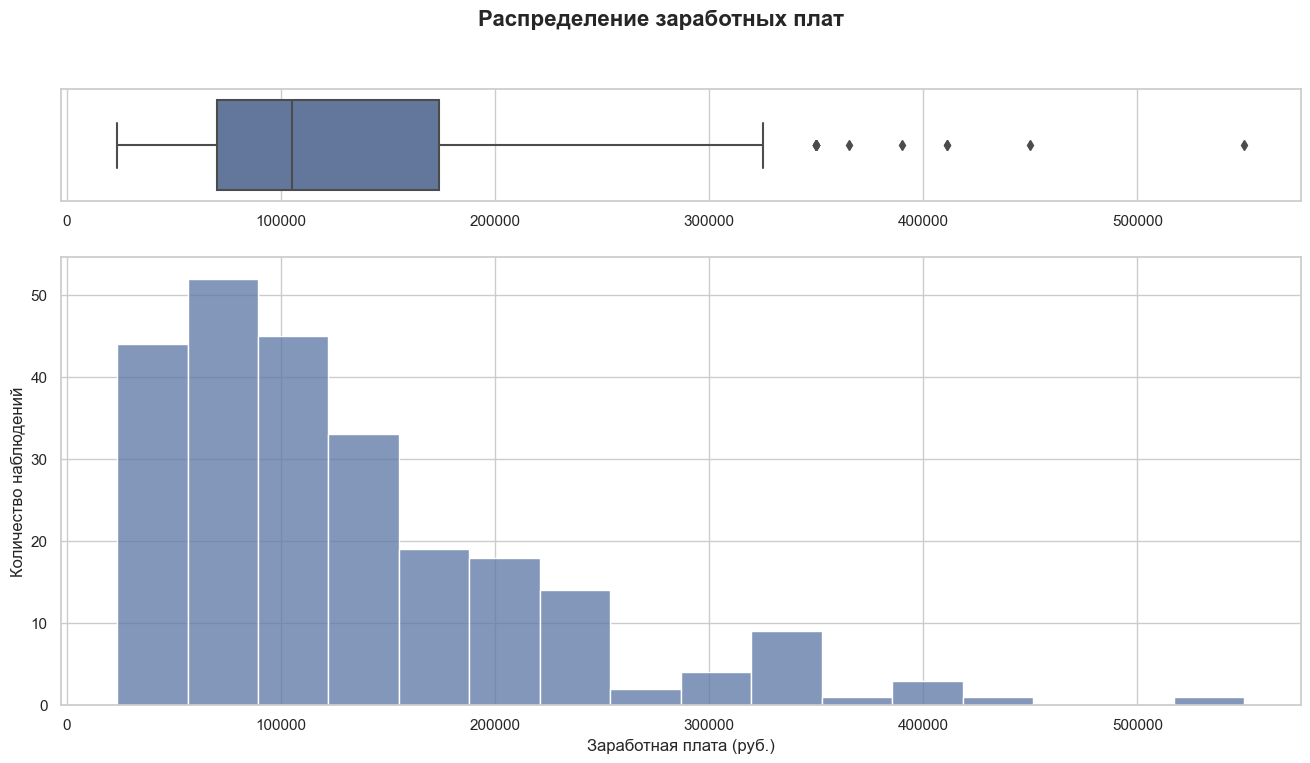

In [42]:
fig, axes = plt.subplots(
    nrows=2, ncols=1, sharex=False, 
    gridspec_kw={"height_ratios": (.2, .8)},
    figsize=(16, 8)
)

sns.boxplot(data=vacancies, x='salary_rub', ax=axes[0], orient='h', color='#5975A4')
sns.histplot(data=vacancies, x='salary_rub', color='#5975A4')
axes[0].set_xlabel('')
axes[1].set_ylabel('Количество наблюдений', fontsize=12)
axes[1].set_xlabel('Заработная плата (руб.)', fontsize=12)

fig.suptitle('Распределение заработных плат', 
            fontsize=16,
            fontweight="bold",
)
plt.show()

Красивое распределение, похожее на распределение зарплаты. Видно, что медианная зарплата немного больше 100 т.р.

### Вывод по предобработке данных:

В процессе предобработки данных был проведен ряд операций, направленных на очистку и структурирование информации для последующего анализа. 

- Во-первых, было замечено наличие пустых списков в колои нк`key_skillon, что может указывать на отсутствие поой информации о требуемых навыкахия вакаийых.
- Во-вторых, для удобства обработки данных была добавлена флаговая переменная, позволяющая различать вакансии аналитиков и датасаентовтис, и две выборки объединены в отов.
- Также было отмечено, что работодатели часто не указывают информацию о зарплате, что усложняет анализ заработных плат по рынку.
- В датасете присутствовали смежные вакансии с названиями "Аналитик данных/Data Scientist", которые были исключены из анализа, так как их нельзя было однозначно отнести к какой-либо из групп, удалив 58 таких запи- ей.
о устанноовить, что данные охватывают период последнего месяца, начиная с 13 апреля 2024 года до 13 мая 2024 года.
- Наблюдаемый рост числа вакансий может быть связан с актуальностью данных, а также с тенденцией закрытия вакансий со временем, что не позволяет судить о реальной динамике рынка труда.
- В датасете представлены вакансии не только из России, но и из ближнего зарубежья.
- Значения в переменной experience были приведены к единому виду, категоризировав опыт работы по четырем группам: Junior, Junior+, Middle и Senior.
- Была проведена лемматизация описаний вакансий, и результаты сохранены в новом столбце.
- Создана переменная, содержащая скиллы вакансии, перечисленные через запятую, и выявлены самые популярм "ms sql".
- Создан столбец с объединенными скиллами, полученными из описания вакансий.
- Создана переменная salary_num, отражающая зарплату в числовом формате или nan, если зарплата не указана.
- Зарплаты, не указанные в рублях, были конвертированы в рубли, и создан новый столбец salary_rub.
- Создана переменная salary_cat, категоризирующая заработные платы.

В результате данных операций, набор данных был значительно очищен и структурирован, что позволит провести более детальный и точный анализ в дальнейшем.

---

## Исследовательский анализ данных

---

### Посмотрим баланс аналитиков и датасаентистов в выборке

Общее количество вакансий - 1341


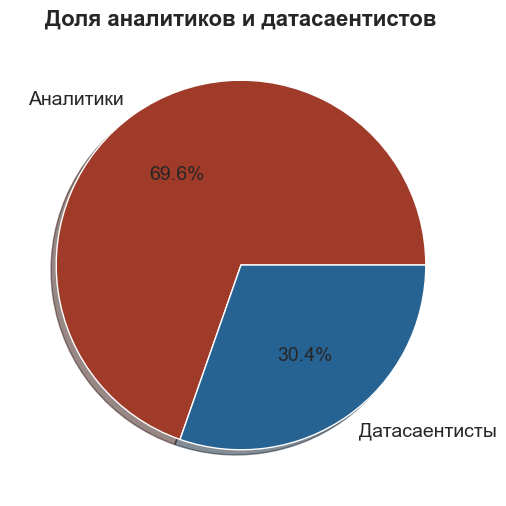

In [43]:
df = vacancies.name_type.value_counts().reset_index()
print(f'Общее количество вакансий - {vacancies.shape[0]}')
colors = [COLORS['da'], COLORS['ds']]

# Устанавливаем тему для графиков
sns.set(style="darkgrid")

# Создаем круговую диаграмму
plt.figure(figsize=(6, 6))  # Устанавливаем размер фигуры
plt.pie(
    df['count'], 
    labels=['Аналитики', 'Датасаентисты'], 
    colors=colors, 
    autopct='%1.1f%%',
    textprops={'fontsize': 14},
    shadow=True,
)

# Устанавливаем заголовок
plt.title(
    'Доля аналитиков и датасаентистов', 
    fontsize=16,
    fontweight="bold"
)

# Отображаем диаграмму
plt.show()

Вакансий аналитиков почти в два с половиной раза больше чем вакансий датасаентистов.

---

### Определение доли грейдов Junior, Junior+, Middle, Senior среди вакансий Аналитик данных и Специалист по Data Science.

Общее количество вакансий аналитиков - 934
Общее количество вакансий датасаентистов - 407


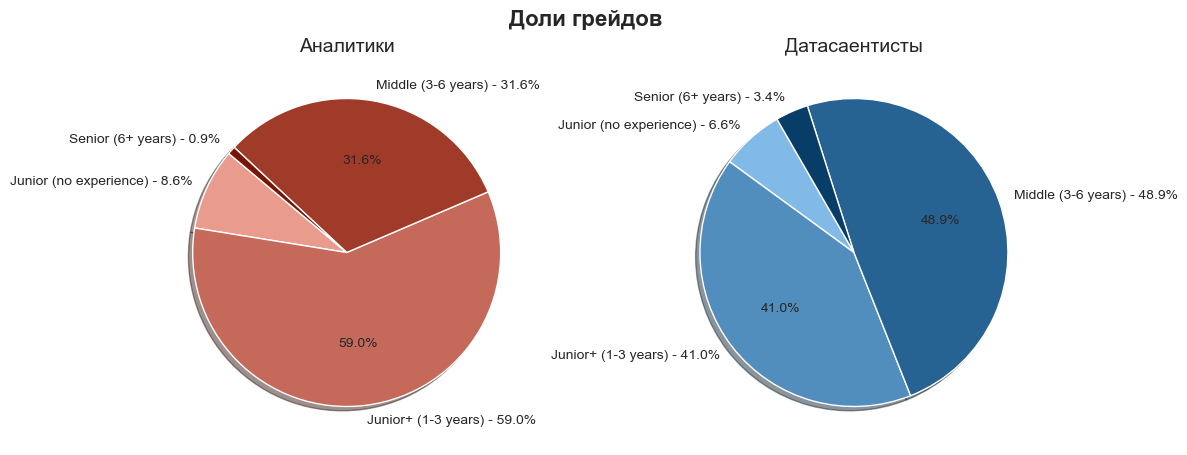

In [44]:
def autopct_generator(limit):
    def inner_autopct(pct):
        return f'{pct:.1f}%' if pct > limit else ''
    return inner_autopct


# получаем данные
df_da = vacancies[vacancies.name_type == 'da'].experience.value_counts().sort_index()
         
df_ds = vacancies[vacancies.name_type == 'ds'].experience.value_counts().sort_index()

# определяем цвета
colors1 = [COLORS_DA[grade] for grade in df_da.index]
colors2 = [COLORS_DS[grade] for grade in df_ds.index]

print(f'Общее количество вакансий аналитиков - {df_da.sum()}')
print(f'Общее количество вакансий датасаентистов - {df_ds.sum()}')

# Создаем фигуру и оси для двух подграфиков
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Круговая диаграмма для аналитиков
axes[0].pie(
      df_da, 
      labels=[lbl + f' - {value / df_da.sum():.1%}' for lbl, value in df_da.items()], 
      autopct=autopct_generator(10), 
      startangle=140, 
      colors=colors1, 
      textprops={'fontsize': 10},
      shadow=True
)
axes[0].set_title('Аналитики', fontsize=14)

# Круговая диаграмма для датасаентистов
axes[1].pie(
    df_ds, 
    labels=[lbl + f' - {value / df_ds.sum():.1%}' for lbl, value in df_ds.items()],
    autopct=autopct_generator(10), 
    startangle=120, 
    colors=colors2,
    textprops={'fontsize': 10},
    shadow=True
    )
axes[1].set_title('Датасаентисты', fontsize=14)

# Добавляем общий заголовок для всех подграфиков
plt.suptitle('Доли грейдов', fontsize=16, fontweight='bold')

# Отображаем график
plt.show()

Анализ распределения грейдов показывает заметные различия между аналитиками и датасаентистами. В рядах аналитиков наибольшим спросом пользуются специалисты уровня Junior+, тогда как среди датасаентистов наиболее востребованы как Middle, так и Junior+ специалисты, которые совместно занимают лидирующие позиции. Кроме того, среди аналитиков наблюдается немного большая потребность в специалистах на уровне Junior без опыта по сравнению с датасаентистами. В то же время, среди вакансий для датасаентистов 3.4% приходится на Senior позиции, в то время как среди вакансий аналитиков доля Senior специалистов составляет менее 1%. Больший спрос на Junior аналитиков без опыта показывает, что аналитику без опыта немного проще найти работу, чем датасаентисту без релевантного опыта работы.

### Названия вакансий для аналитиков и датасаентистов

In [45]:
def plot_top_popular_values(vacancies: pd.DataFrame, column: str, *, title: str, 
                            rus_feature: str, top_n: int = 10, da_shift: float = 165, 
                            ds_shift: float = 72, height: float = 4, top: float = 0.8, 
                            wspace: float = 0.83, lower: float = 0.2) -> None:
    """
    Построение горизонтальных столбчатых диаграмм для двух категорий вакансий.

    Функция создает две горизонтальные столбчатые диаграммы, отображающие топ-N популярных значений 
    для указанного столбца в датасете вакансий, разделенных по категориям 'Аналитики данных' и 'Датасаентисты'.

    Parameters:
    vacancies (pd.DataFrame): Датафрейм с информацией о вакансиях.
    column (str): Имя столбца в датафрейме, по которому будет строиться график.
    title (str): Общий заголовок для всех графиков.
    rus_feature (str): Название оси Y на русском языке.
    top_n (int): Количество топовых значений для отображения.
    da_shift (float): Смещение текста для категории 'Аналитики данных'.
    ds_shift (float): Смещение текста для категории 'Датасаентисты'.
    height (float): Высота фигуры графика.
    top (float): Пропорция верхней части фигуры.
    wspace (float): Пропорция пространства между графиками.
    lower (float): Нижнее смещение текста на графиках.

    Returns:
    None
    """
    
    # создаем основу для двух графиков и определяем размер
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(18, height)

    # получаем данные для графиков
    data_da = vacancies.loc[vacancies.name_type == 'da', column].value_counts()
    data_da_share = data_da / data_da.sum()

    data_ds = vacancies.loc[vacancies.name_type == 'ds', column].value_counts()
    data_ds_share = data_ds / data_ds.sum()

    # Создаем горизонтальную столбчатую диаграмму
    sns.barplot(x=data_da[:top_n], y=data_da.index[:top_n], color=COLORS['da'], ax=axes[0])
    sns.barplot(x=data_ds[:top_n], y=data_ds.index[:top_n], color=COLORS['ds'], ax=axes[1])

    # Добавляем текстовые метки для каждого столбца на графиках
    for i, val in enumerate(data_da_share.values[:top_n]):
        axes[0].text(da_shift, i + lower, f"{round(val*100, 1)}%", 
                     horizontalalignment='center', 
                     verticalalignment='bottom', 
                     fontdict={'fontweight':500, 'size':10, 'color': 'black'})

    for i, val in enumerate(data_ds_share.values[:top_n]):
        axes[1].text(ds_shift, i + lower, f"{round(val*100, 1)}%", 
                     horizontalalignment='center', 
                     verticalalignment='bottom', 
                     fontdict={'fontweight':500, 'size':10, 'color': 'black'})

    # Устанавливаем заголовок и размер шрифта
    fig.suptitle(title, fontsize=16, fontweight="bold")
    # устанавливаем названия
    axes[0].set_title('Аналитики данных', fontsize=14)
    axes[1].set_title('Датасаентисты', fontsize=14)
    axes[0].set_xlabel('количество наблюдений', fontsize=12)
    axes[1].set_xlabel('количество наблюдений', fontsize=12)
    axes[0].set_ylabel(rus_feature, fontsize=12)
    axes[1].set_ylabel(rus_feature, fontsize=12)
    plt.subplots_adjust(wspace=wspace, top=top)

    # Отображаем график
    plt.show()

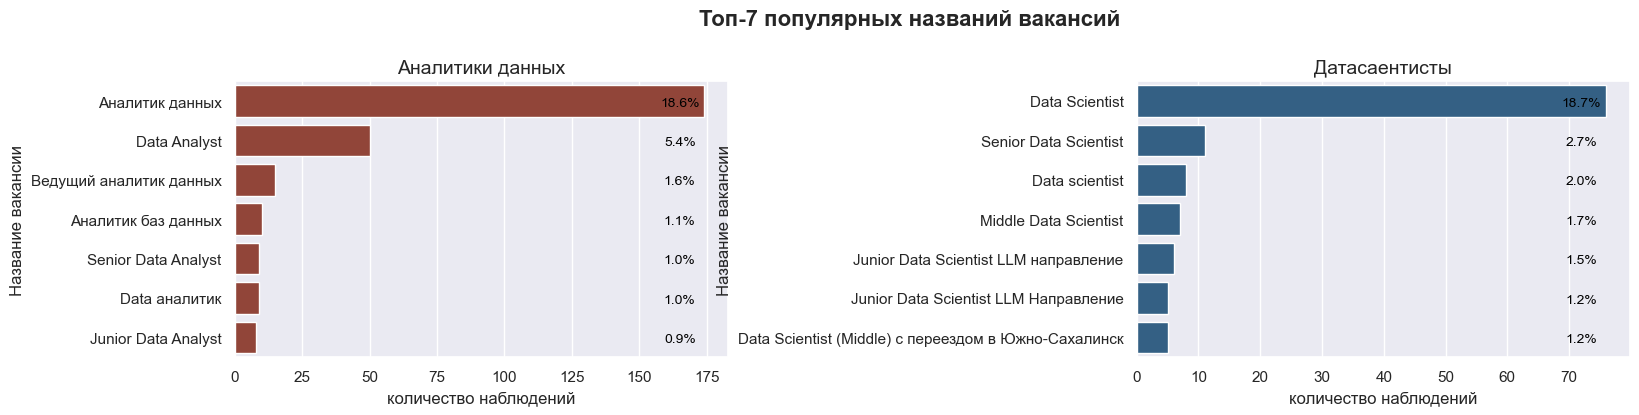

In [46]:
plot_top_popular_values(
    vacancies, 
    'name', 
    title='Топ-7 популярных названий вакансий', 
    rus_feature='Название вакансии',
    top_n=7
)

Как видно из данных, наиболее востребованными на рынке труда являются позиции "Аналитик данных", "Data Analyst" и "Data Scientist". Это говорит о том, что соискателям, вероятно, не следует усложнять название своей специализации при поиске работы. Простота и понятность названия профессии могут оказаться ключевыми в успешном трудоустройстве. Среди датасаентистов видно, что сейчас тренд на работу с большими текстовыми моделями.

---

### Топ работодателей по количеству вакансий

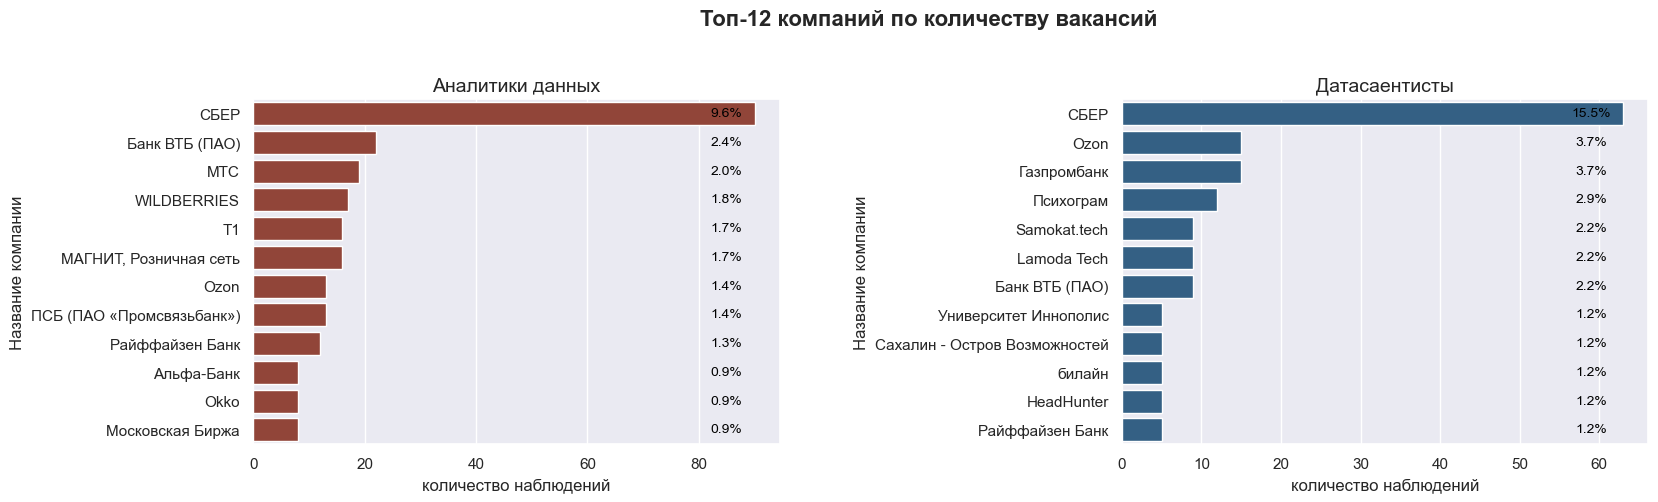

In [47]:
plot_top_popular_values(
    vacancies=vacancies,
    column='employer',
    top_n=12,
    title='Топ-12 компаний по количеству вакансий',
    rus_feature='Название компании',
    da_shift=85,
    ds_shift=59,
    height=5, 
    top=0.8,
    wspace=0.65
)

На текущем рынке труда СБЕР выделяется как неоспоримый лидер по количеству предложений о работе. Интересно отметить, что в таких компаниях, как WILDBERRIES, ВТБ и МТС, наблюдается повышенный спрос на аналитиков данных по сравнению с датасаентистами. В то же время, в компаниях OZON, Газпромбанк и Samokat.tech, наоборот, профессия датасаентиста пользуется большей популярностью, чем аналитика данных. Это подчеркивает разнообразие потребностей в специалистах по обработке данных на рынке, где каждая компания стремится найти подходящего специалиста, отвечающего её уникальным требованиям.

---

### Топ городов по количеству вакансий

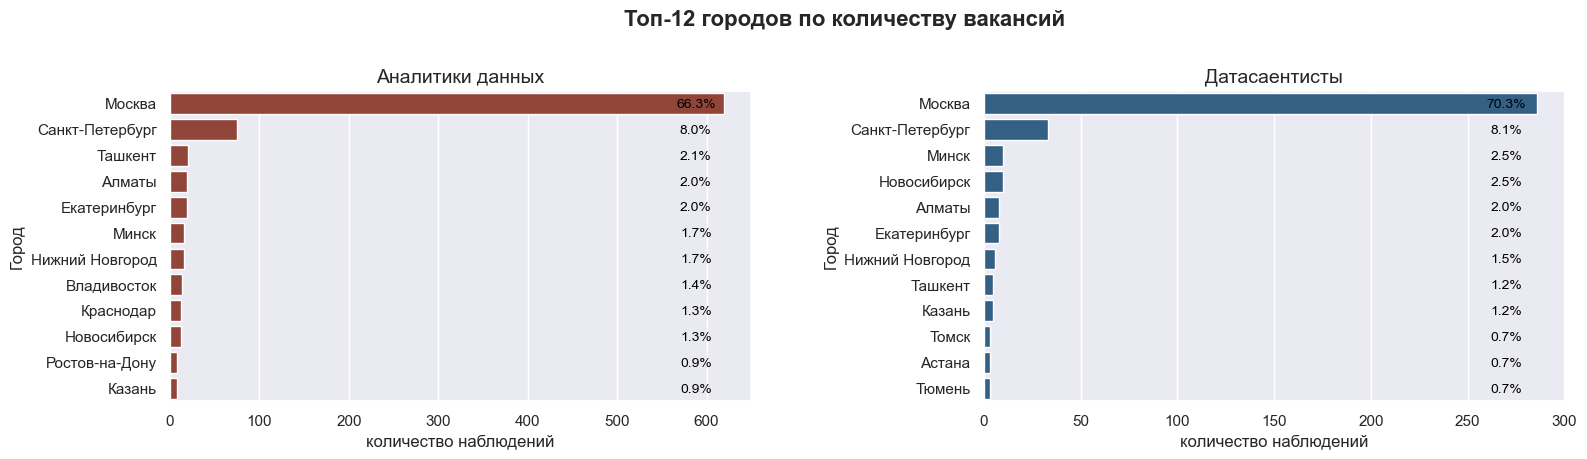

In [48]:
plot_top_popular_values(
    vacancies=vacancies,
    column='area',
    top_n=12,
    title='Топ-12 городов по количеству вакансий',
    rus_feature='Город',
    da_shift=588,
    ds_shift=270,
    height=4.5, 
    top=0.8,
    wspace=0.4,
    lower=0.27
)

Москва и Санкт-Петербург неизменно занимают лидирующие позиции по объему предложений работы, подтверждая свой статус крупнейших трудовых центров.

---

### Вывод по исследовательскому анализу:

- На рынке труда в сфере анализа данных прослеживается четкая тенденция: вакансий для аналитиков в полтора раза больше, чем для датасаентистов, что указывает на более широкие возможности трудоустройства в данной области. Специалисты уровня Junior+ пользуются наибольшим спросом среди аналитиков, в то время как среди датасаентистов больше ценятся специалисты среднего уровня (Middle) и Junior+. Это может свидетельствовать о различных требованиях к опыту работы в зависимости от специализации.

- СБЕР выступает как лидер по числу вакансий, что подчеркивает его значимость на рынке. Отличие в спросе на аналитиков и датасаентистов в различных компаниях подтверждает, что каждый работодатель ищет специалистов, соответствующих уникальным требованиям и задачам. Москва и Санкт-Петербург сохраняют свои позиции как основные центры трудоустройства в сфере аналитики данных.и.

## Наиболее желаемые кандидаты на вакансии Аналитик данных и Специалист по Data Science

Посмотрим какие скиллы чаще всего хочет видеть работодатель у аналитиков, и у датасаентистов.

In [49]:
def get_frequency_skill(type_name: str, experience: str) -> pd.DataFrame:
    """
    Вычисляет частоту встречаемости навыков для заданного типа вакансий и уровня опыта.

    Функция принимает тип вакансии и уровень опыта, а затем анализирует набор данных вакансий,
    чтобы определить, как часто каждый навык упоминается в соответствующих записях.

    Parameters:
    type_name (str): Тип вакансии, например 'da' для аналитиков данных.
    experience (str): Уровень опыта, например 'senior'.

    Returns:
    pd.DataFrame: DataFrame с топ-15 наиболее часто встречающимися навыками и их частотами.
    """
    
    # Словарь для подсчета частоты встречаемости навыков
    freq_skills = {}
    
    # Перебираем список навыков для заданного типа вакансий и уровня опыта
    for sequence in vacancies[(vacancies.name_type == type_name) & (vacancies.experience == experience)].skills.to_list():
        skills = sequence.split(', ')
        if skills:
            for skill in skills:
                freq_skills[skill] = freq_skills.get(skill, 0) + 1
    
    # Объединяем частоты для синонимичных навыков
    freq_skills['excel'] = freq_skills.get('ms excel', 0) + freq_skills.get('excel', 0)
    freq_skills.pop('ms excel', None)
    
    freq_skills['power bi'] = freq_skills.get('ms power bi', 0) + freq_skills.get('power bi', 0)
    freq_skills.pop('ms power bi', None)
    
    freq_skills['powerpoint'] = freq_skills.get('ms powerpoint', 0) + freq_skills.get('powerpoint', 0)
    freq_skills.pop('ms powerpoint', None)
    
    freq_skills['spark'] = freq_skills.get('pyspark', 0) + freq_skills.get('spark', 0)
    freq_skills.pop('pyspark', None)
    
    # Удаляем слишком общие навыки
    freq_skills.pop('анализ данных', None)
    freq_skills.pop('machine learning', None)
    freq_skills.pop('ml', None)
    freq_skills.pop('data science', None)
    
    # Сортируем навыки по убыванию частоты встречаемости
    freq_skills = dict(sorted(freq_skills.items(), key=lambda item: item[1], reverse=True))
    
    # Ограничиваем список до топ-15 навыков
    skill = list(freq_skills.keys())[:15]
    freq = list(freq_skills.values())[:15]
    
    # Создаем DataFrame и сортируем его по частоте встречаемости
    return pd.DataFrame({'Скилл': skill, 'Частота встречаемости': freq}).sort_values(by='Частота встречаемости', ascending=False)


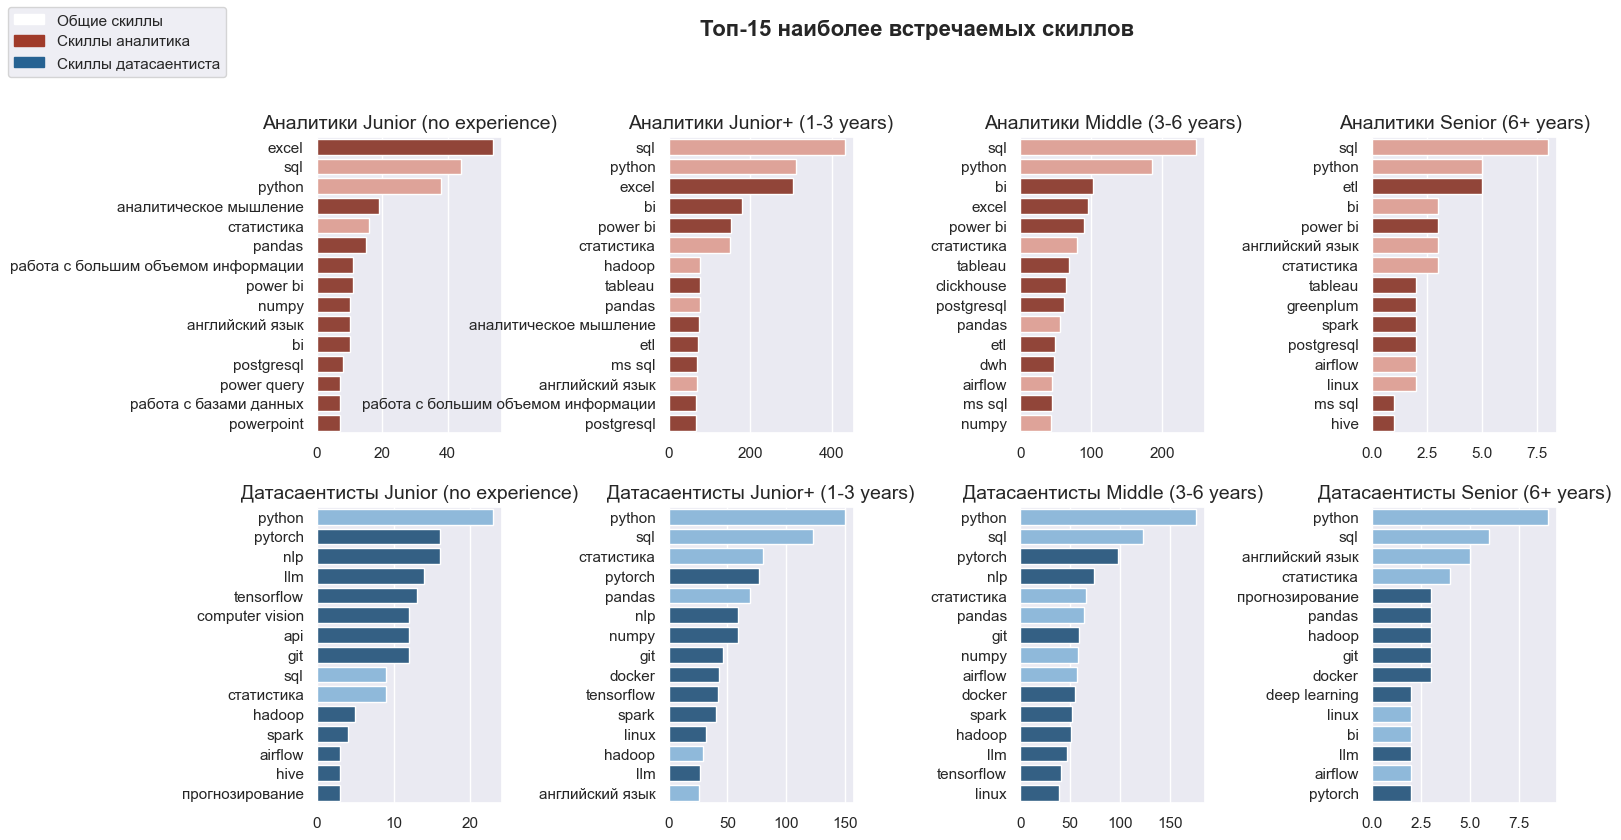

In [50]:
# Создаем фигуру с сеткой подграфиков
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
fig.suptitle('Топ-15 наиболее встречаемых скиллов', fontsize=16, fontweight='bold')

grades = ("Junior (no experience)", 
          "Junior+ (1-3 years)", 
          "Middle (3-6 years)", 
          "Senior (6+ years)")

# Создаем столбчатые диаграммы для каждого уровня опыта
for i, name_experience in enumerate(grades):
    freq_skills_da = get_frequency_skill('da', name_experience)
    freq_skills_ds = get_frequency_skill('ds', name_experience)

    # Определяем общие и уникальные скиллы
    common_skills = set(freq_skills_da['Скилл']).intersection(set(freq_skills_ds['Скилл']))
    da_unique_skills = set(freq_skills_da['Скилл']).difference(common_skills)
    ds_unique_skills = set(freq_skills_ds['Скилл']).difference(common_skills)

    # Устанавливаем цвета для скиллов
    freq_skills_da['color'] = freq_skills_da['Скилл'].apply(
        lambda x: COLORS_DA['Junior (no experience)'] if x in common_skills else COLORS['da']
        )
    freq_skills_ds['color'] = freq_skills_ds['Скилл'].apply(
        lambda x: COLORS_DS['Junior (no experience)'] if x in common_skills else COLORS['ds']
        )
    
    # Аналитики
    sns.barplot(x='Частота встречаемости', y='Скилл', data=freq_skills_da,
                palette=freq_skills_da['color'], ax=axes[0, i])
    axes[0, i].set_title(f"Аналитики {name_experience}", fontsize=14)
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel('')
    
    # Датасаентисты
    sns.barplot(x='Частота встречаемости', y='Скилл', data=freq_skills_ds,
                palette=freq_skills_ds['color'], ax=axes[1, i])
    axes[1, i].set_title(f"Датасаентисты {name_experience}", fontsize=14)
    axes[1, i].set_xlabel('')
    axes[1, i].set_ylabel('')

# настраиваем расположение графиков
black_patch = mpatches.Patch(color='white', label='Общие скиллы')
analyst_patch = mpatches.Patch(color=COLORS['da'], label='Скиллы аналитика')
datascience_patch = mpatches.Patch(color=COLORS['ds'], label='Скиллы датасаентиста')
plt.subplots_adjust(wspace=0.9, hspace=0.25, top=0.85)
fig.legend(handles=[black_patch, analyst_patch, datascience_patch], loc='upper left')
plt.show()


### Вывод по исследованию навыков:

- Изучение рынка вакансий показывает, что независимо от уровня и специализации, работодатели ценят знание SQL, Python и основ статистики у кандидатов. Для аналитиков на всех уровнях, кроме Senior, важен навык работы с Excel, тогда как для более опытных аналитиков этот инструмент уже не является приоритетным. Отличительной чертой для вакансий аналитиков является также умение работать с BI системами, такими как Power BI и Tableau. При переходе на уровень Junior+ аналитика, приобретает значение владение ETL процессами и инструментами, включая Airflow. Для Senior аналитиков ключевыми становятся знания Spark и Greenplum.

- Вакансии датасаентистов выделяются требованиями к специализированным навыкам в области машинного обучения, включая ML, PyTorch и NLP, а также востребованностью таких инструментов, как Docker и Spark. Кроме того, для специалистов Data Science на всех уровнях необходимо знание системы контроля версий Git.

---

## Определение типичного места работы для Аналитика данных и специалист по Data Science

---

In [51]:
def plot_top_popular_values8x(vacancies: pd.DataFrame, feature: str, title: str) -> None:
    """
    Создает столбчатые диаграммы для различных уровней опыта аналитиков и датасаентистов.

    Функция принимает DataFrame с вакансиями, название интересующего признака и заголовок графика.
    Строит столбчатые диаграммы для топ-10 значений указанного признака для каждой группы опыта.

    Parameters:
    vacancies (pd.DataFrame): DataFrame с информацией о вакансиях.
    feature (str): Название признака для анализа.
    title (str): Заголовок для всей сетки графиков.
    """
    
    # Создаем фигуру с сеткой подграфиков
    fig, axes = plt.subplots(2, 4, figsize=(18, 7))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Определяем уровни опыта
    grades = ("Junior (no experience)", 
              "Junior+ (1-3 years)", 
              "Middle (3-6 years)", 
              "Senior (6+ years)")
    
    # Создаем столбчатые диаграммы для каждого уровня опыта
    for i, name_experience in enumerate(grades):
        # Получаем топ-10 значений для аналитиков
        top_da = vacancies[
            (vacancies.name_type == 'da') & (vacancies.experience == name_experience)
            ][feature].value_counts()[:10]
        top_da.index = top_da.index.map(lambda x: x if len(x) < 20 else x[:18] + '...')
        # Получаем топ-10 значений для датасаентистов
        top_ds = vacancies[
            (vacancies.name_type == 'ds') & (vacancies.experience == name_experience)
            ][feature].value_counts()[:10]
        top_ds.index = top_ds.index.map(lambda x: x if len(x) < 20 else x[:18] + '...')
    
        # Рисуем столбчатые диаграммы для аналитиков
        sns.barplot(y=top_da.index, x=top_da, color=COLORS_DA[name_experience], ax=axes[0, i])
        axes[0, i].set_title(f"Аналитики {name_experience}", fontsize=14)
        axes[0, i].set_xlabel('')
        axes[0, i].set_ylabel('')
        # Рисуем столбчатые диаграммы для датасаентистов
        sns.barplot(y=top_ds.index, x=top_ds, color=COLORS_DS[name_experience], ax=axes[1, i])
        
        # Устанавливаем подзаголовки для каждого подграфика
        axes[1, i].set_title(f"Датасаентисты {name_experience}", fontsize=14)  
        axes[1, i].set_xlabel('')
        axes[1, i].set_ylabel('')
    
    plt.subplots_adjust(wspace=1.4, hspace=0.25, top=0.85)
    # Отображаем график
    plt.show()


Рассмотрим топ-10 работодателей по количеству вакансий

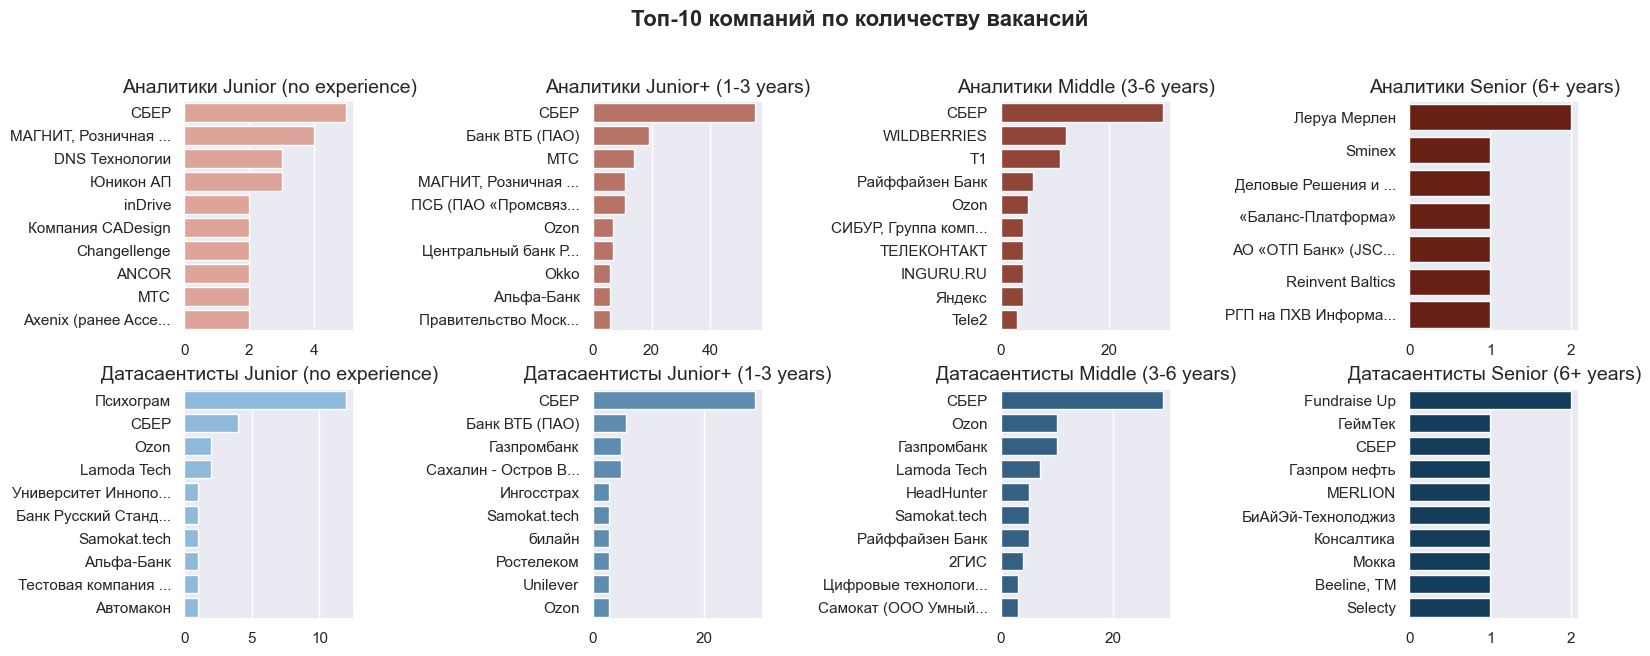

In [52]:
plot_top_popular_values8x(vacancies, 'employer', 'Топ-10 компаний по количеству вакансий')

Анализируя рынок труда, можно отметить, что Сбербанк доминирует по количеству вакансий, исключая позиции Senior. Магнит также выделяется как один из лидеров в привлечении джуниор-аналитиков, как с опытом, так и без. Банк ВТБ занимает прочное второе место по числу предложений для начинающих аналитиков и специалистов по данным с небольшим опытом. Онлайн-ритейлеры, такие как OZON и Wildberries, также активно ищут новые кадры, предлагая множество вакансий в этих сегментах.

In [53]:
def plot_share(
        vacancies: pd.DataFrame, feature: str, title: str, n_axes_legend=0, 
        bbox_to_anchor_up=(-0.5, 1.4), bbox_to_anchor_down=(-0.5, 0.2), wspace=0.2) -> None:
    """
    Создает круговые диаграммы для различных уровней опыта аналитиков и датасаентистов.

    Функция принимает DataFrame с вакансиями, название интересующего признака и заголовок графика.
    Строит круговые диаграммы для каждой группы опыта, отображая распределение указанного признака.

    Parameters:
    vacancies (pd.DataFrame): DataFrame с информацией о вакансиях.
    feature (str): Название признака для анализа.
    title (str): Заголовок для всей сетки графиков.
    """
    
    # Создаем фигуру с сеткой подграфиков
    fig, axes = plt.subplots(2, 4, figsize=(16, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.87)
    
    # Определяем уровни опыта
    grades = ("Junior (no experience)", 
              "Junior+ (1-3 years)", 
              "Middle (3-6 years)", 
              "Senior (6+ years)")
    
    # Создаем круговые диаграммы для каждого уровня опыта
    for i, name_experience in enumerate(grades):
        # Получаем данные для аналитиков
        da_share = vacancies.loc[(vacancies['experience'] == name_experience) & (vacancies.name_type == 'da'), feature].value_counts()
        # Получаем данные для датасаентистов
        ds_share = vacancies.loc[(vacancies['experience'] == name_experience) & (vacancies.name_type == 'ds'), feature].value_counts()
        
        # Рисуем круговую диаграмму для аналитиков
        axes[0, i].pie(
            da_share, labels=[lbl if val > da_share.sum() * 0.01 else '' for lbl, val in da_share.items()],
            autopct=autopct_generator(10), 
            startangle=140, 
            colors=[COLORS_DA[key] for key in da_share.index], 
            textprops={'fontsize': 10},
            shadow=True
        )
        axes[0, i].set_title(f"Аналитики {name_experience}")
        
        # Рисуем круговую диаграмму для датасаентистов
        axes[1, i].pie(
            ds_share, labels=[lbl if val > ds_share.sum() * 0.01 else '' for lbl, val in ds_share.items()],
            autopct=autopct_generator(10), 
            startangle=90, 
            colors=[COLORS_DS[key] for key in ds_share.index], 
            textprops={'fontsize': 10},
            shadow=True
            )
            
        axes[1, i].set_title(f"Датасаентисты {name_experience}")
    
    fig.subplots_adjust(hspace=-0.3, wspace=wspace)
    axes[0, n_axes_legend].legend(loc='upper left', bbox_to_anchor=bbox_to_anchor_up)
    axes[1, n_axes_legend].legend(loc='upper left', bbox_to_anchor=bbox_to_anchor_down)
      
    # Отображаем график
    plt.show()

Рассмотрим распределение типов занятости

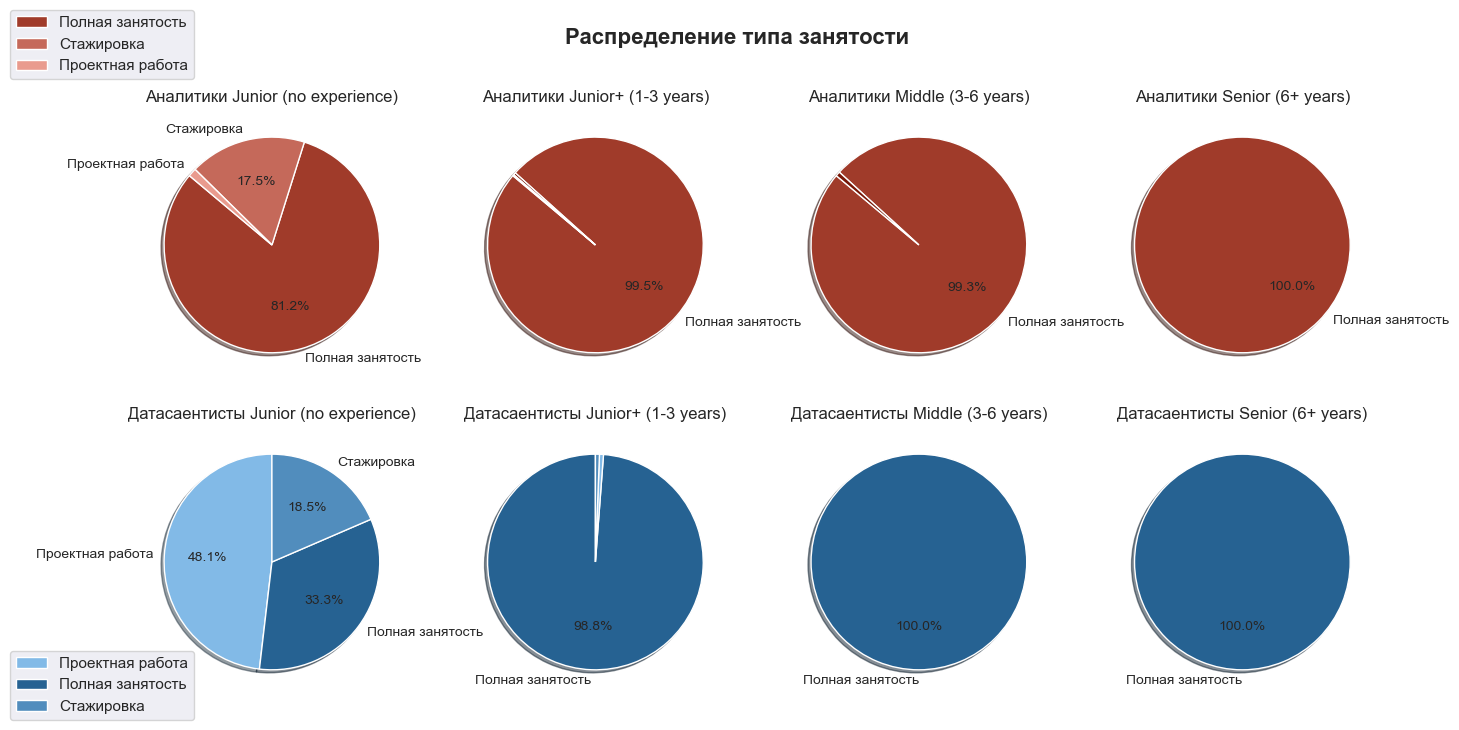

In [54]:
plot_share(vacancies, 'employment', 'Распределение типа занятости')

Из анализа данных рынка труда следует, что для большинства категорий специалистов, за исключением начинающих аналитиков без опыта, тип занятости, указанный в вакансиях, в основном представлен полной занятостью. Однако, около 18% вакансий, для джуниор специалистов без опыта, предлагают стажировку. Почти половина вакансий Junior датасаентистов без опыта с типом занятости - проектная работа.

Рассмотрим распределение графика работы

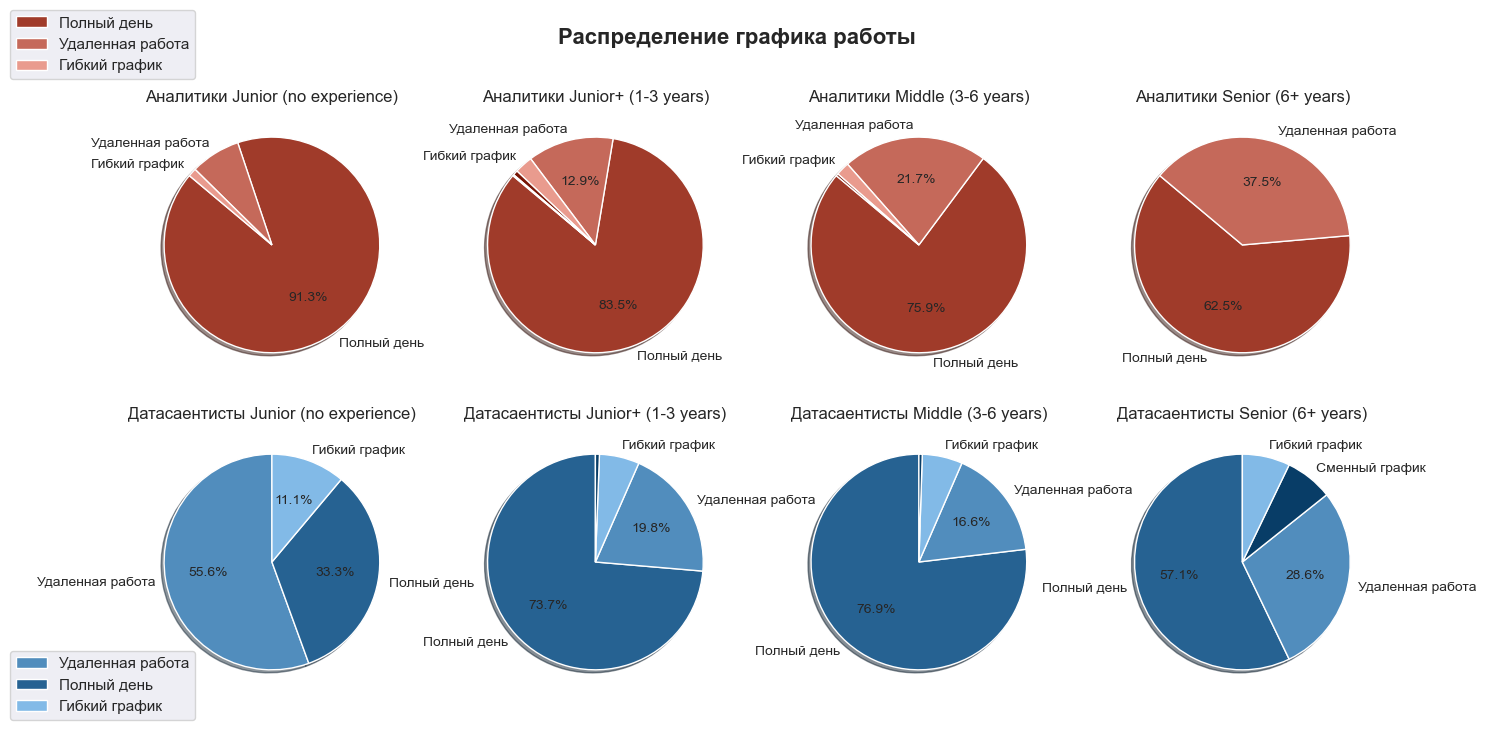

In [55]:
plot_share(vacancies, 'schedule', 'Распределение графика работы')

Из данных следует, что с увеличением требуемого уровня опыта у кандидатов на позиции аналитиков возрастает и доля вакансий, предлагающих возможность удаленной работы. В то же время, в сфере Data Science наблюдается обратная тенденция: только треть вакансий для начинающих специалистов без опыта предусматривают полный рабочий день. Для более опытных специалистов этот показатель находится в диапазоне 57%-77%.

Посмотрим как распределены заработные платы по каждой категории.

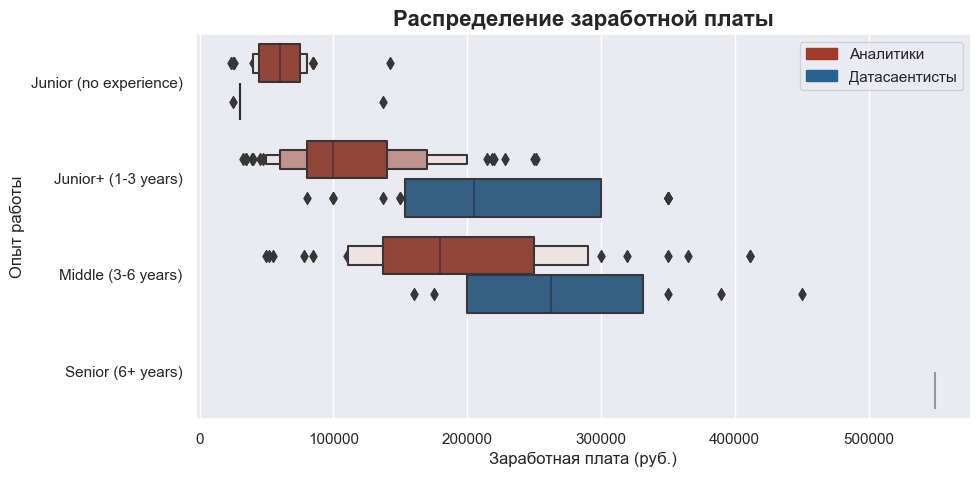

In [56]:
order = vacancies.groupby(['name_type', 'experience']).agg({'salary_rub': 'median'}).reset_index().iloc[:4]['experience']
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxenplot(data=vacancies, x='salary_rub', y='experience', hue='name_type', palette=[COLORS['da'], COLORS['ds']], order=order, ax=ax)
ax.set_title('Распределение заработной платы', fontsize=16, fontweight='bold')
ax.set_ylabel('Опыт работы')
ax.set_xlabel('Заработная плата (руб.)')


analyst_patch = mpatches.Patch(color=COLORS['da'], label='Аналитики')
datascience_patch = mpatches.Patch(color=COLORS['ds'], label='Датасаентисты')

plt.legend(handles=[analyst_patch, datascience_patch], loc='upper right')

plt.show()

Имеющиеся данные по уровням зарплат показывают, что для начинающих специалистов без опыта и для экспертов с высоким уровнем квалификации информация носит фрагментарный характер, что затрудняет формирование полной картины по типичным доходам в этих категориях. Однако можно отметить, что зарплатные ожидания аналитиков на уровнях junior+ и middle оказываются ниже, чем у их коллег-датасаентистов с аналогичным опытом. Так, медианная зарплата аналитика на уровне junior+ составляет около 100 тыс. рублей, в то время как для датасаентиста этой же категории — более 200 тыс. рублей. Для специалистов middle уровня разрыв также ощутим: медианная зарплата аналитика не достигает 200 тыс. рублей, тогда как у датасаентиста она превышает 250 тыс. рублей.

Посмотрим как распределены категории заработной платы.

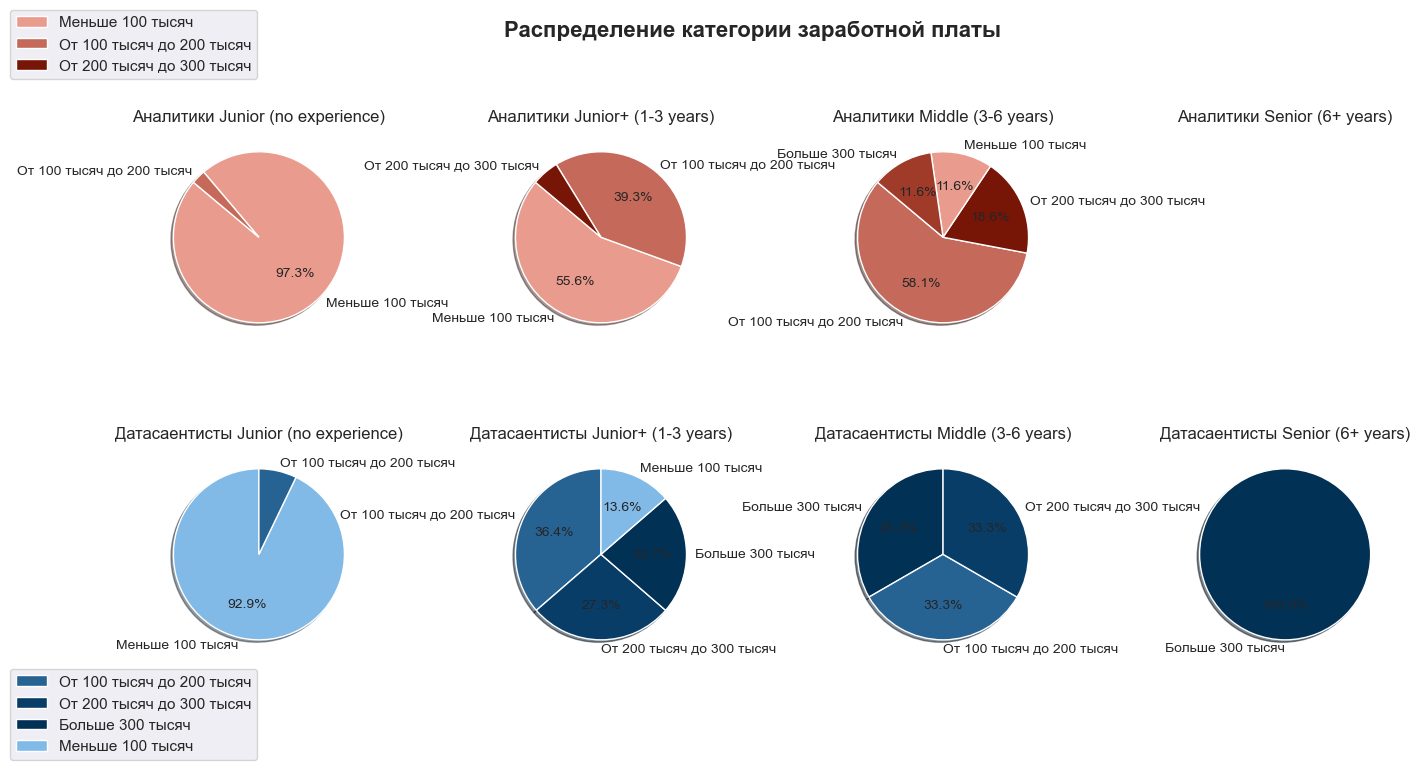

In [57]:
plot_share(
    vacancies[~vacancies.salary_rub.isna()], 
    'salary_bin', 
    'Распределение категории заработной платы', 
    n_axes_legend=1,
    bbox_to_anchor_up=(-2.3, 1.6),
    bbox_to_anchor_down=(-2.3, 0),
    wspace=0.6
    )

Из анализа рынка труда следует, что начинающие специалисты без опыта работы часто сталкиваются с предложениями зарплаты, не превышающими 100 тыс. рублей. В то же время, более половины аналитиков с небольшим опытом (Junior+) также получают доход на уровне до 100 тыс. рублей. Среди датасаентистов на уровне Junior+ большинство зарплат находится в диапазоне от 100 до 200 тыс. рублей. Аналогичный уровень дохода характерен и для аналитиков Middle, которые, как правило, зарабатывают от 100 до 200 тыс. рублей. Отмечается значительный разброс в зарплатах среди Junior+ и Middle датасаентистов, а также Middle аналитиков, что указывает на широкий спектр возможностей и вариативность доходов в данных сегментах рынка.

### Вывод по исследованию типичного места работы:
Анализ рынка труда в сфере аналитики данных и Data Science позволяет сделать несколько ключевых выводов:
1. **Работодатели**: Сбербанк выделяется как лидер по количеству вакансий, о за исключением позиций Senior. Магнит и ВТБ также активно привлекают начинающих аналитикоак компании OZON и Wildberrieтоже входят в число лидеров по количеству ваканисийо.2. **Тип занятости**: Для большинства категорий специалистов, кроме начинающих аналитиков без опыта, вакансии предлагают полную занятость. Стажировки и проектная работа чаще всего предлагаются джуниорам без опыта.
3. **Удаленная работа и опыт**: С ростом уровня опыта у аналитиков увеличивается доля предложений о возможности удаленной работы. В сфере Data Science наблюдается обратная тенденция, с меньшим количеством рабочих мест для начинающих имеющих полный рабочий день.
4. **Уровни зарплат**: Данные по зарплатам показывают, что как правило начинающие специалисты без опыта работы получают зарплату меньше 100 т.р. Зарпату Senior специалистов невозможно оценить из-за недостатка данных. Сравнивая зарплаты junior+  и middle специалистов, можно заметить что как правило зарплаты датасаентистов выше зарплат аналитиков.



## Общий вывод:

*Исследование рынка труда в области аналитики данных и Data Science выявило ряд важных тенденций, которые могут служить руководством как для специалистов, ищущих работу, так и для компаний, стремящихся привлечь квалифицированные кадры.*


Во-первых, аналитики данных востребованы на рынке труда более чем в полтора раза по сравнению с датасаентистами, что отражает более широкий спектр возможностедля трудоустройства в в этой области. Спрос на специалистов уровня Junior+ особенно высок среди аналитиков, тогда как для датасаентистов преобладают позиции Middle и Junior+. Это подчеркивает различия в требованиях к уровню опыта в зависимости от специализации


Сбербанк, Магнит и ВТБ выделяются как основные работодатели в сфере аналитики данных, предлагая множество вакансий для начинающих специалистов. Компании OZON и Wildberries также активно ищут новые кадры, что свидетельствует о живом интересе к сфере азатики данн
х.

По типу занятости большинство вакансий предлагают полную занятость, за исключением начинспециалистовитиков, для которых также доступны стажировки и проектная работа. С увеличением опыта у аналитиков растет и доля предлосений о возмьюжности удаленной работы, в то время как в Data Scобратная тенденцияражена.

В отношении заработных плат заметен разрыв между ожиданиями аналитиков и датасаентистов. Начинающие аналитики часто сталкиваются с зарплатами ниже 100 тыс. рублей, в то время как датасаентисты на уровне Junior+ и Middle имеют более высокие доходы.

*В целом, исследование подтверждает, что рынок труда в сфере аналитики данных и Data Science является динамичным и разнообразным, предлагая множество возможностей для специалистов различного уровня. Это требует от соискателей гибкости, а от компаний — четкого понимания своих потребностей в специалистах и умения привлекать нужные кадры.*

## Описание идеальных кандидатов

Функции для расчета итоговых таблиц

In [58]:
def calc_ideal_candidate(name_type: str) -> None:
    """
    Отображает таблицу с ранжированием навыков по их частоте встречаемости для различных уровней опыта в заданной категории вакансий.

    Parameters:
    name_type (str): Категория вакансии ('da' для аналитиков данных или 'ds' для датасаентистов).
    """
    # Собираем данные о частоте навыков для каждого уровня опыта
    table = pd.concat([get_frequency_skill(name_type, grade)['Скилл'] for grade in grades], axis=1)
    table.columns = grades  # Присваиваем названия колонок в соответствии с уровнями опыта
    display(table)  # Отображаем таблицу
    print('Чем выше навык в таблице, тем он важнее для соответствующего уровня опыта.')

def calc_salary_mode(ser: pd.Series) -> pd.Series:
    """
    Вычисляет моду зарплат из серии, исключая записи, где зарплата не указана.

    Parameters:
    ser (pd.Series): Серия значений зарплат.

    Returns:
    pd.Series: Мода зарплатной серии.
    """
    return ser[ser != 'ЗП не указана'].mode()  # Возвращаем моду, исключая записи "ЗП не указана"

def calc_typical_place(name_type: str) -> pd.DataFrame:
    """
    Собирает и возвращает таблицу с типичными характеристиками мест работы для заданной категории вакансий.

    Функция агрегирует данные по работодателям, типам занятости, графикам работы и категориям зарплат для каждого уровня опыта.
    Результат представляется в виде таблицы, которая может быть использована для анализа типичных условий работы в отрасли.

    Parameters:
    name_type (str): Категория вакансии ('da' для аналитиков данных или 'ds' для датасаентистов).

    Returns:
    pd.DataFrame: Таблица с типичными характеристиками мест работы.
    """
    idx = ['Работодатель', 'Тип занятости', 'График работы', 'Заработная плата']
    # Агрегируем данные по каждому уровню опыта и каждой характеристике места работы
    table = pd.concat(
        [vacancies[(vacancies.name_type == name_type) & (vacancies.experience == grade)]
         .agg(dict(zip(['employer', 'employment', 'schedule', 'salary_bin'], [pd.Series.mode]*3 + [calc_salary_mode])))
         .T for grade in grades], axis=1
    ).fillna('Нет данных')[0]  # Заполняем отсутствующие данные
    table.index = idx  # Назначаем индекс таблицы
    table.columns = grades  # Назначаем названия колонок
    return table

### Таблица навыков идеальных кандидатов в аналитики данных

In [59]:
calc_ideal_candidate('da')

,Junior (no experience),Junior+ (1-3 years),Middle (3-6 years),Senior (6+ years)
0,excel,sql,sql,sql
1,sql,python,python,python
2,python,excel,bi,etl
3,аналитическое мышление,bi,excel,bi
4,статистика,power bi,power bi,power bi
5,pandas,статистика,статистика,английский язык
6,работа с большим объемом информации,hadoop,tableau,статистика
7,power bi,tableau,clickhouse,tableau
8,numpy,pandas,postgresql,greenplum
9,английский язык,аналитическое мышление,pandas,spark


Чем выше навык в таблице, тем он важнее для соответствующего уровня опыта.


### Таблица навыков идеальных кандидатов на вакансию data scientist

In [60]:
calc_ideal_candidate('ds')

,Junior (no experience),Junior+ (1-3 years),Middle (3-6 years),Senior (6+ years)
0,python,python,python,python
1,pytorch,sql,sql,sql
2,nlp,статистика,pytorch,английский язык
3,llm,pytorch,nlp,статистика
4,tensorflow,pandas,статистика,прогнозирование
5,computer vision,nlp,pandas,pandas
6,api,numpy,git,hadoop
7,git,git,numpy,git
8,sql,docker,airflow,docker
9,статистика,tensorflow,docker,deep learning


Чем выше навык в таблице, тем он важнее для соответствующего уровня опыта.


## Описание типичного места работы

### Таблица типичного места работы аналитика данных

In [61]:
calc_typical_place('da')

,Junior (no experience),Junior+ (1-3 years),Middle (3-6 years),Senior (6+ years)
Работодатель,СБЕР,СБЕР,СБЕР,Леруа Мерлен
Тип занятости,Полная занятость,Полная занятость,Полная занятость,Полная занятость
График работы,Полный день,Полный день,Полный день,Полный день
Заработная плата,Меньше 100 тысяч,Меньше 100 тысяч,От 100 тысяч до 200 тысяч,Нет данных


### Таблица типичного места работы специалиста по Data Science

In [62]:
calc_typical_place('ds')

,Junior (no experience),Junior+ (1-3 years),Middle (3-6 years),Senior (6+ years)
Работодатель,Психограм,СБЕР,СБЕР,Fundraise Up
Тип занятости,Проектная работа,Полная занятость,Полная занятость,Полная занятость
График работы,Удаленная работа,Полный день,Полный день,Полный день
Заработная плата,Меньше 100 тысяч,От 100 тысяч до 200 тысяч,Больше 300 тысяч,Больше 300 тысяч


## Рекомендации для курса "Аналитик данных"

Так как студенты курса, как правило не имеют опыта работы аналитиком данных, стоит прежде всего смотреть на стек технологий для junior специалистов без опыта работы. 
- Так как Excel является одним из ключевых навыков Аналитика данных, вплоть до Middle специалиста, следует включить в состав курса спринт по этому навыку. Также в этот спринт стоит добавить работу с языком запросов Power Query.
- Среди bi систем, как показывает исследование, самой популярной среди работодателей является Power Bi. Также для работы этой системы не требуется VPN как для работы c Tableau, а популяризация VPN запрещена с 1 марта 2024 года.
- Среди популярных навыков которые хотят видеть работодатели присутствует библиотека Numpy, а знакомство с ней к сожалению отсутствует в курсе. К тому же знакомство с библиотекой Pandas лучше начинать, через Numpy, так ка Pandas написана на основе этой библиотеки.
- Также необходимо добавить обучение с каким-нибудь средством создания презентаций, самым популярным из которых является Power Point.

## Рекомендации для курса "Data Science"

- Самой популярной библиотекой для обучения нейронных сетей является Pytorch поэтому необходимо заменить Keras.
- Стоит больше часов распределить на работы с большими текстовыми моделями и моделями компьютерного зрения, судя по ключевым навыкам это самые востребованные направления в Data Science.
- Стоит выделить отдельный спринт для работы с большими данными (Hive, Hadoop, Spark)
- А также стоит молодым специалистам стоит изучать airflow, для создания пайплайнов.